# An Earth-Venus-Earth Link Budget from Open Research Institute
This document contains a detailed link budget analysis for Earth-Venus-Earth (EVE) communications. It begins with a Python dataclass for each fixed earth station. Dataclasses are a type of Python object where only variables are declared. No methods are included. The site-specific dataclasses have parameters that are true for the site regardless of the target. Following the site-specific dataclasses are link budget classes, which contain target-specific values and methods that return various gains and losses. The most important output of a link budget object is a carrier to noise ratio at a particular receive bandwidth. A link budget class inherits a particular site dataclass. The site-specific dataclasses and the link budgets can be mixed and matched. This gives flexibility, as a link budget for a particular target, such as EVE, can be calculated for different sites by having that link budget inherit different site-specific dataclasses. 

## What is a Link Budget?

If you have ever dealt with income and monthly bills, then you have probably used a budget. A budget is a balance between an amount of something coming into an account or collection, and an amount of something going out. A link budget uses the same concepts as a financial budget, with income (gain) and expenses (losses) counted up over a period of time and space. The link in link budget is the physical path or link between transmitter and receiver. Like finanical budgeting, link budgets can range from a very simple picture of finacial activity to a very complex accounting of a wide variety of types of income and expenses. A simple link budget can be very useful. A complex one can be very wrong. A high quality link budget is accurate, accessible, and flexible. Link budgets can be used in a variety of ways. The most familiar role is predictive, where a link budget is used to design a communications experiment or system implementation. Link budgets can also be used as documentation. These are accurate only after the fact of a communications experiment or system implementation. Finally, link budgets are an excellent educational resource, providing a system-level view of radio communications. The goal for this link budget is to be useful in all three of these roles: predictive, documenary, and educational. 

## EVE compared to EME
The communications mode most similar to EVE is Earth-Moon-Earth (EME). EVE is more complex than EME communications due to several factors:

1. Much greater distances involved
2. Greater variability in the distances involved
3. Doppler rate of change due orbital positions of Earth and Venus changing with respect to each other
4. Different signal reflection characteristics from Venus compared to the Moon
5. Doppler spreading

## Contributors
Including but not limited to Michelle Thompson, Matthew Wishek, Paul Williamson, Rose Easton, Thomas Telkamp, Pete Wyckoff, Gary K6MG, and Lee Blanton. Questions or comments about this document? Please file an issue in the repository or write hello at operesearch dot institute.

## Imports

We import the python modules that we need for the project.

In [80]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any
from skyfield.api import load, wgs84
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import plotly.io as pio
pio.renderers.default = "notebook"

## Dataclass Definitions

We set up dataclasses using the naming format SiteNameLinkParameters. We use numbers we have been given from sites such as Deep Space Exploration Society (DSES), who first asked for assistance with this project. This first part of the link budget sets the values that are true for these sites regardless of the celestial target. For example, 1296 MHz (23cm band) is a common frequency for EME communications, and is the starting point for EVE at DSES. Using a frequency closer to ~2450 MHz would give a bit better performance, and there are plans to move to 2304 MHz in 2026. Therefore, variables such as the frequency used at DSES site (tx_frequency_mhz) are set in DSESLinkParameters data classes.

In [81]:
# Dataclass Definitions
@dataclass
class DSESLinkParameters: #things that are true for the site regardless of the target
    # location of this dish in Google Earth is 38°22'51"N 103°09'22"W
    latitude: float = 38.380833 # from FCC converter
    longitude: float = -103.156111 # from FCC converter
    elevation: float = 1311 # meters, from online calculator
    tx_frequency_mhz: float = 1296.0 # Transmit frequency
#    tx_frequency_mhz: float = 2304.0 # Transmit frequency anticipated for October 2026
    tx_power_w: float = 1500.0 # Transmit power in watts
    tx_antenna_diameter_m: float = 18.29 # Transmit antenna diameter
    tx_antenna_efficiency: float = 0.69 # Transmit antenna efficiency
    rx_antenna_diameter_m: float = 18.29 # Receive antenna diameter
    rx_antenna_efficiency: float = 0.69 # Receive antenna efficiency
    tx_line_loss_db: float = 0.5 # provided
    rx_line_loss_db: float = 0.5 # provided
    pointing_error_deg: float = 0.01 # provided
    lna_noise_figure_db: float = 0.4 # from datasheet for the Kuhne MKU LNA 132 AH SMA
    lna_noise_figure_K: float = 290 * (10**(lna_noise_figure_db/10) - 1) # calculated from lna_noise_figure_db
    receiver_noise_bandwidth: float = 100e3 # operational receiver bandwidth. 
    c: float = 299792458  # Speed of light in m/s
    k: float = 1.380649e-23  # Boltzmann constant in J/K
    t0: float = 290  # Reference temperature in K


@dataclass
class DwingelooLinkParameters: #things that are true for the site regardless of the target
    latitude: float = 52.81213723180477 # from Thomas
    longitude: float = 6.396346463227839 # from Thomas
    elevation: float = 70.26 # from Thomas
    tx_frequency_mhz: float = 1299.0 # Transmit frequency from Thomas
#    tx_frequency_mhz: float = 2304.0 # Transmit frequency anticipated for October 2026
    tx_power_w: float = 1000.0 # Transmit power in watts
    tx_antenna_diameter_m: float = 25 # Transmit antenna diameter from Thomas
    tx_antenna_efficiency: float = 0.69 # Transmit antenna efficiency from Thomas
    rx_antenna_diameter_m: float = 25 # Receive antenna diameter from Thomas
    rx_antenna_efficiency: float = 0.69 # Receive antenna efficiency from Thomas
    tx_line_loss_db: float = 0.5 # best guess
    rx_line_loss_db: float = 0.5 # best guess
    pointing_error_deg: float = 0.01 # best guess
    lna_noise_figure_db: float = 0.629 # best guess working backwards from a Tsys = 65 measured recently from Thomas
    lna_noise_figure_K: float = 290 * (10**(lna_noise_figure_db/10) - 1) # calculated from lna_noise_figure_db
    receiver_noise_bandwidth: float = 100e3 # operational receiver bandwidth. 
    c: float = 299792458  # Speed of light in m/s
    k: float = 1.380649e-23  # Boltzmann constant in J/K
    t0: float = 290  # Reference temperature in K

## Select the Site

Select the site we want to use for the link budget by setting the variable SiteLinkParameters to the name of the desired dataclass.  

In [82]:
SiteLinkParameters = DwingelooLinkParameters

## System Noise Temperature Worksheet

### Introduction

The system noise temperature is an important factor in determining the sensitivity of a radio telescope or communication system. It represents the total noise from all sources that affects the system's ability to detect weak signals. It is measured in Kelvin (K).

Unlike signal strength, which scales with dish diameter, system noise temperature is largely independent of the physical size of the antenna. Instead, it depends on factors related to the quality of the antenna construction, receiver electronics, and environmental conditions.

### Key Components

This system noise temperature calculation has the following components

1. Sky Noise (T_sky): Background radiation from the whole universe anda model of atmospheric contributions. This varies with elevation angle (more atmosphere at lower angles) and weather conditions (clear, cloudy, rainy).

2. Spillover Noise (T_spillover): Noise caused by the antenna feed pattern transmitting energy beyond the dish edges. This means it also picks up thermal radiation from the ground. This is determined by the feed design and positioning.

3. Scatter Noise (T_scatter): Noise resulting from dish surface imperfections that scatter incoming signals. Calculated using the Ruze equation, which relates surface RMS errors to performance degradation at a given wavelength.

4. Receiver Noise (T_receiver): Noise generated by the receiver's electronic components, often specified as noise figure or noise temperature.

### Total System Temperature

The total system noise temperature is calculated as:

T_sys = T_ant + T_receiver

Where T_ant (the antenna temperature) is the combination of sky noise, spillover noise, and scatter noise:

T_ant = (main_beam_efficiency * T_sky) + T_spillover + T_scatter

### Impact on Performance

A lower system noise temperature directly translates to better sensitivity. For deep space communications, like those with Venus, minimizing each noise component is essential. The main ways to do this are to use high-quality low-noise amplifiers (LNAs). This is a very important factor in reducing receiver noise. Precise dish surfaces minimize scatter noise. If they're out of round or warped, then there's a degradation. Well-designed feeds reduce spillover noise. The feed needs to be matched as well as it can be to the dish dimension. Operating at higher elevation angles when possible reduces sky noise because we're going through less of the atmosphere. 

This worksheet implements some calculations for each of these noise components. The goal is to produce a realistic system performance assessment, and to provide a solid system noise temperature to the Link Budget calculation. 

In [83]:
#import numpy as np
#from dataclasses import dataclass
#from typing import Optional, Dict, Any

class SystemNoiseTemperature:
    """
    A class to calculate system noise temperature for radio systems.
    """
    
    def __init__(self, params: 'SiteLinkParameters'):
        """
        Initialize the system noise temperature calculator.
        
        Parameters:
        params (SiteLinkParameters): The link parameters object containing system settings
        """
        self.params = params
    
    def calculate_sky_noise(self, elevation_angle_deg: float, atmospheric_conditions: str = 'clear') -> float:
        """
        Calculate sky noise temperature based on frequency and elevation angle.
        
        Parameters:
        elevation_angle_deg (float): Elevation angle in degrees
        atmospheric_conditions (str): Weather conditions ('clear', 'cloudy', 'rain')
        
        Returns:
        float: Sky noise temperature in Kelvin
        """
        # Convert elevation angle to radians
        elev_rad = np.radians(elevation_angle_deg)
        
        # Basic atmospheric attenuation model
        base_temp = 2.7  # cosmic background radiation
        
        # Atmospheric contribution increases at lower elevation angles
        air_mass = 1.0 / np.sin(elev_rad)
        
        # Frequency dependent atmospheric absorption
        freq_ghz = self.params.tx_frequency_mhz / 1000.0
        freq_factor = 0.1 * freq_ghz / 10.0
        
        # Weather condition factors
        weather_factors = {
            'clear': 1.0,
            'cloudy': 1.5,
            'rain': 3.0
        }
        
        weather_multiplier = weather_factors.get(atmospheric_conditions, 1.0)
        
        return base_temp + (270 * (1 - np.exp(-freq_factor * air_mass))) * weather_multiplier

    def calculate_spillover_noise(self, spillover_efficiency: float, ground_temp: float = 290.0) -> float:
        """
        Calculate spillover noise contribution.
        
        Parameters:
        spillover_efficiency (float): Efficiency of the antenna's spillover (0-1)
        ground_temp (float): Ground temperature in Kelvin
        
        Returns:
        float: Spillover noise temperature in Kelvin
        """
        return ground_temp * (1 - spillover_efficiency)

    def calculate_scatter_noise(self, surface_rms_mm: float) -> float:
        """
        Calculate scattering noise due to surface imperfections using the Ruze equation.
        
        Parameters:
        surface_rms_mm (float): Root mean square surface error in mm
        
        Returns:
        float: Scatter noise temperature in Kelvin
        """
        wavelength_mm = 300000 / self.params.tx_frequency_mhz  # Convert MHz to wavelength in mm
        surface_efficiency = np.exp(-(4 * np.pi * surface_rms_mm / wavelength_mm) ** 2)
        return 290 * (1 - surface_efficiency)

    def calculate_system_noise(self, 
                              main_beam_efficiency: float,
                              spillover_efficiency: float,
                              surface_rms_mm: float,
                              receiver_temp: float,
                              elevation_angle_deg: float,
                              atmospheric_conditions: str = 'clear',
                              ground_temp: float = 290.0) -> Dict[str, float]:
        """
        Calculate total system noise temperature and its components.
        
        Parameters:
        main_beam_efficiency (float): Main beam efficiency of the antenna (0-1)
        spillover_efficiency (float): Spillover efficiency of the antenna (0-1)
        surface_rms_mm (float): RMS surface error in mm
        receiver_temp (float): Receiver noise temperature in Kelvin
        elevation_angle_deg (float): Elevation angle in degrees
        atmospheric_conditions (str): Weather conditions ('clear', 'cloudy', 'rain')
        ground_temp (float): Ground temperature in Kelvin
        
        Returns:
        Dict[str, float]: Dictionary containing total and component temperatures
        """
        # Calculate individual components
        sky_noise = self.calculate_sky_noise(elevation_angle_deg, atmospheric_conditions)
        spillover_noise = self.calculate_spillover_noise(spillover_efficiency, ground_temp)
        scatter_noise = self.calculate_scatter_noise(surface_rms_mm)
        
        # Calculate antenna temperature
        t_ant = (main_beam_efficiency * sky_noise + 
                spillover_noise + scatter_noise)
        
        # Calculate total system temperature
        t_sys = t_ant + receiver_temp
        
        return {
            'T_sys': t_sys,
            'T_ant': t_ant,
            'T_sky': sky_noise,
            'T_spillover': spillover_noise,
            'T_scatter': scatter_noise,
            'T_receiver': receiver_temp
        }

    def get_noise_temperature_summary(self, **kwargs) -> Dict[str, Any]:
        """
        Returns a comprehensive summary of noise temperature calculations.
        
        Parameters:
        **kwargs: Keyword arguments that can override default parameters
                 (main_beam_efficiency, spillover_efficiency, surface_rms_mm, 
                  receiver_temp, elevation_angle_deg, atmospheric_conditions)
        
        Returns:
        Dict[str, Any]: Dictionary with noise temperature results and parameters used
        """
        # Default values (these could/should be stored in SiteLinkParameters instead)
        defaults = {
            'main_beam_efficiency': 0.69,
            'spillover_efficiency': 0.95,
            'surface_rms_mm': 0.3,
            'receiver_temp': self.params.lna_noise_figure_K,  
            'elevation_angle_deg': 45.0,
            'atmospheric_conditions': 'clear',
            'ground_temp': 290.0
        }
        
        # Override defaults with any provided keyword arguments. 
        # we got a lot of good advice on the defaults, but if we know
        # about some sort of update or change to the defaults, then we
        # provide them to the noise calculator get_noise_temperature_summary method. 
        params = {**defaults, **kwargs}
        
        # Calculate system noise
        noise_temps = self.calculate_system_noise(
            main_beam_efficiency=params['main_beam_efficiency'],
            spillover_efficiency=params['spillover_efficiency'],
            surface_rms_mm=params['surface_rms_mm'],
            receiver_temp=params['receiver_temp'],
            elevation_angle_deg=params['elevation_angle_deg'],
            atmospheric_conditions=params['atmospheric_conditions'],
            ground_temp=params['ground_temp']
        )
        
        # Add parameters used for calculation to results
        result = {
            'noise_temperatures': noise_temps,
            'parameters_used': params,
            'frequency_mhz': self.params.tx_frequency_mhz 
        }
        
        return result

    
# Create calculator
params = SiteLinkParameters()
noise_calculator = SystemNoiseTemperature(params)

# Get full noise temperature analysis with default parameters
results = noise_calculator.get_noise_temperature_summary(
)

# Print results
print(f"System Noise Analysis at {results['frequency_mhz']} MHz:")
print(f"Elevation: {results['parameters_used']['elevation_angle_deg']}°")
print(f"Conditions: {results['parameters_used']['atmospheric_conditions']}")
print("\nNoise Temperatures:")
for key, value in results['noise_temperatures'].items():
    print(f"  {key}: {value:.1f} K")



# Get full noise temperature analysis with compromised session parameters
results = noise_calculator.get_noise_temperature_summary(
    elevation_angle_deg=5.0,  # Lower elevation than default - this is a keyword argument change
    atmospheric_conditions='cloudy'  # Worse conditions than default - this is a keyword argument change
)

# Print results
print(f"System Noise Analysis at {results['frequency_mhz']} MHz:")
print(f"Elevation: {results['parameters_used']['elevation_angle_deg']}°")
print(f"Conditions: {results['parameters_used']['atmospheric_conditions']}")
print("\nNoise Temperatures:")
for key, value in results['noise_temperatures'].items():
    print(f"  {key}: {value:.1f} K")


System Noise Analysis at 1299.0 MHz:
Elevation: 45.0°
Conditions: clear

Noise Temperatures:
  T_sys: 65.0 K
  T_ant: 19.8 K
  T_sky: 7.6 K
  T_spillover: 14.5 K
  T_scatter: 0.1 K
  T_receiver: 45.2 K
System Noise Analysis at 1299.0 MHz:
Elevation: 5.0°
Conditions: cloudy

Noise Temperatures:
  T_sys: 100.3 K
  T_ant: 55.1 K
  T_sky: 58.8 K
  T_spillover: 14.5 K
  T_scatter: 0.1 K
  T_receiver: 45.2 K


## EVELinkBudget Class
This link budget class is EVELinkBudget. It targets Venus as a reflective surface. We inherit site specific link parameters (SiteNameLinkParameters) as params and can call upon them in the class. We then set up all our EVE/Venus specific values and define the functions that we need in order to calculate this specific link budget. 

We add up all the gains and subtract the losses. This gives power at the receiver. We calculate the noise in our receive bandwidth, and subtract it from power at the receiver. This gives a carrier to noise ratio in dB. Our communications mode must be able to meet this CNR in order to close the link. 

In [84]:
# Define the EVE link budget here - [ ] # Venus specific
class EVELinkBudget: 
    def __init__(self, params: SiteLinkParameters):
        self.params = params

        # Venus characteristics
        self.venus_radius_km = 6051.8  # Venus radius in km
        self.venus_radar_albedo = 0.152  # see Venus radar albedo (Radio Echo Observations of Venus and Mercury at 23 cm Wavelength, 1965)
                                         # see Variations in the Radar Cross Section of Venus J. V. Evans Lincoln Laboratory,
                                         # Massachusetts Institute of Technology (Received 19 December 1967)

    
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency"""
        return self.params.c / (self.params.tx_frequency_mhz * 1e6)

    def venus_reflection_gain(self) -> float:
        """Calculate reflection gain from Venus surface
        Venus radar cross section = π * radius²"""
        # see also https://hamradio.engineering/eme-path-loss-free-space-loss-passive-reflector-loss/
        venus_radius_m = self.venus_radius_km * 1000
        radar_cross_section = np.pi * venus_radius_m**2
        return 10 * np.log10(radar_cross_section)

    def venus_reflection_loss(self) -> float:
        # use radar albedo for Venus to get this loss
        return 10 * np.log10(self.venus_radar_albedo)
    
    def tx_antenna_gain(self) -> float:
        """Calculate transmitter antenna gain"""
        efficiency = self.params.tx_antenna_efficiency
        diameter = self.params.tx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)
    
    def rx_antenna_gain(self) -> float:
        """Calculate receiver antenna gain"""
        efficiency = self.params.rx_antenna_efficiency
        diameter = self.params.rx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)

    def free_space_loss(self, distance_km: float, round_trip: bool = True) -> float:
        """Calculate free space loss, optionally for round trip
        
        Args:
            distance_km: Distance in kilometers
            round_trip: If True, calculate round trip loss (both directions)
        """
        wavelength = self.wavelength()
        distance_m = distance_km * 1000
        one_way_loss = 20 * np.log10(4 * np.pi * distance_m / wavelength)
        return one_way_loss * 2 if round_trip else one_way_loss
    
    def pointing_loss(self) -> float:
        """Calculate pointing loss"""
        pointing_error_rad = np.radians(self.params.pointing_error_deg)
        #tracking_error_rad = np.radians(self.params.tracking_error_deg) # if we know tracking error
        total_error_rad = np.sqrt(pointing_error_rad**2)
        #total_error_rad = np.sqrt(pointing_error_rad**2 + tracking_error_rad**2) # if we know tracking error
        return -12 * (total_error_rad / self.antenna_beamwidth_rad())**2
    
    def antenna_beamwidth_rad(self) -> float:
        """Calculate antenna beamwidth in radians"""
        return 1.22 * self.wavelength() / self.params.tx_antenna_diameter_m
    
    def calculate_link_budget(self, distance_km: float) -> dict:
        """Calculate complete link budget for a given distance"""
        # Convert transmit power to dBW
        tx_power_dbw = 10 * np.log10(self.params.tx_power_w)
        
        # Calculate antenna gains (only once each for TX and RX)
        tx_gain = self.tx_antenna_gain()
        rx_gain = self.rx_antenna_gain()
        venus_gain = self.venus_reflection_gain()
        
        # Calculate losses
        fs_loss = self.free_space_loss(distance_km, round_trip=True)
        point_loss = self.pointing_loss()
        venus_loss = self.venus_reflection_loss()
        
        # Calculate received power (passive reflection scenario)
        rx_power = (
            tx_power_dbw 
            + tx_gain  # TX antenna gain
            + rx_gain  # RX antenna gain
            - fs_loss  # Two-way path loss
            - self.params.tx_line_loss_db  # reported TX line loss at site
            - self.params.rx_line_loss_db  # reported RX line loss at site
            - point_loss  # Pointing loss - needs attention
            - venus_loss  # Venus reflection loss
            + venus_gain  # Venus reflection gain
        )
        

        # Get full noise temperature analysis from our noise_calculator and then use the calculated Tsys
        results = noise_calculator.get_noise_temperature_summary(
            #elevation_angle_deg=5.0,  # Lower elevation than default - this is a keyword argument change
            #atmospheric_conditions='cloudy'  # Worse conditions than default - this is a keyword argument change
        )
        t_sys = results['noise_temperatures']['T_sys']
        
        noise_dbw = 10 * np.log10(self.params.k * t_sys * self.params.receiver_noise_bandwidth)

        
        # Calculate CNR
        cnr = rx_power - noise_dbw

        # Calculate CNR in 1Hz
        bandwidth_factor_db = 10 * np.log10(self.params.receiver_noise_bandwidth / 1)
        cnr_db_1hz = cnr + bandwidth_factor_db
        
        return {
            'tx_power_dbw': tx_power_dbw,
            'radius_venus_km': self.venus_radius_km,
            'venus_radar_albedo': self.venus_radar_albedo,
            'tx_gain_db': tx_gain,
            'rx_gain_db': rx_gain,
            'free_space_loss_db': fs_loss,
            'pointing_loss_db': point_loss,
            'venus_reflection_loss_db': venus_loss,
            'venus_reflection_gain_db': venus_gain,
            'system_noise_temperature': t_sys,
            'rx_power_dbw': rx_power,
            'noise_dbw': noise_dbw,
            'cnr_db': cnr,
            'cnr_db_1hz': cnr_db_1hz
        }

        

## Link Budget Calculator Setup
We fetch all the siteLinkParameters and then create a calculator instance by saying EVELinkBudget(params). 
We've specified the class of EVELinkBudget. We're now creating an object where we can call the various methods inside of that class, which includes our calculate_link_budget(). Since the distance to Venus varies quite a bit, this is a parameter we need to provide. 

Whenever we need to calculate the CNR for our link, we call our_results = calculator.calculate_link_budget(distance to Venus). our_results['cnr_db_1hz'] would be the resulting 1 Hz CNR. 

In [85]:
# Cell 2: Create calculator instance
params = SiteLinkParameters()
calculator = EVELinkBudget(params)

min_distance_km = 38_000_000  # Minimum Earth-Venus distance
max_distance_km = 261_000_000  # Maximum Earth-Venus distance

# Print detailed results for minimum and maximum distances - can then be used in following cells
max_results = calculator.calculate_link_budget(max_distance_km)
min_results = calculator.calculate_link_budget(min_distance_km)

print(f"Link Budget at Minimum Distance (38 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in min_results.items():
    print(f"{key}: {value:.2f}")

print(f"\nLink Budget at Maximum Distance (261 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in max_results.items():
    print(f"{key}: {value:.2f}")

Link Budget at Minimum Distance (38 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 30.00
radius_venus_km: 6051.80
venus_radar_albedo: 0.15
tx_gain_db: 49.03
rx_gain_db: 49.03
free_space_loss_db: 492.63
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
system_noise_temperature: 65.03
rx_power_dbw: -216.79
noise_dbw: -160.47
cnr_db: -56.32
cnr_db_1hz: -6.32

Link Budget at Maximum Distance (261 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 30.00
radius_venus_km: 6051.80
venus_radar_albedo: 0.15
tx_gain_db: 49.03
rx_gain_db: 49.03
free_space_loss_db: 526.11
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
system_noise_temperature: 65.03
rx_power_dbw: -250.26
noise_dbw: -160.47
cnr_db: -89.79
cnr_db_1hz: -39.79


## Effect of Distance on Received Power and Carrier-to-Noise Ratio

The variation in distance from Earth to Venus results in a large variation in the received power at the site and in the carrier to noise ratio at the site. This visualization shows the differences between the closest path and the furthest path for radio work. 

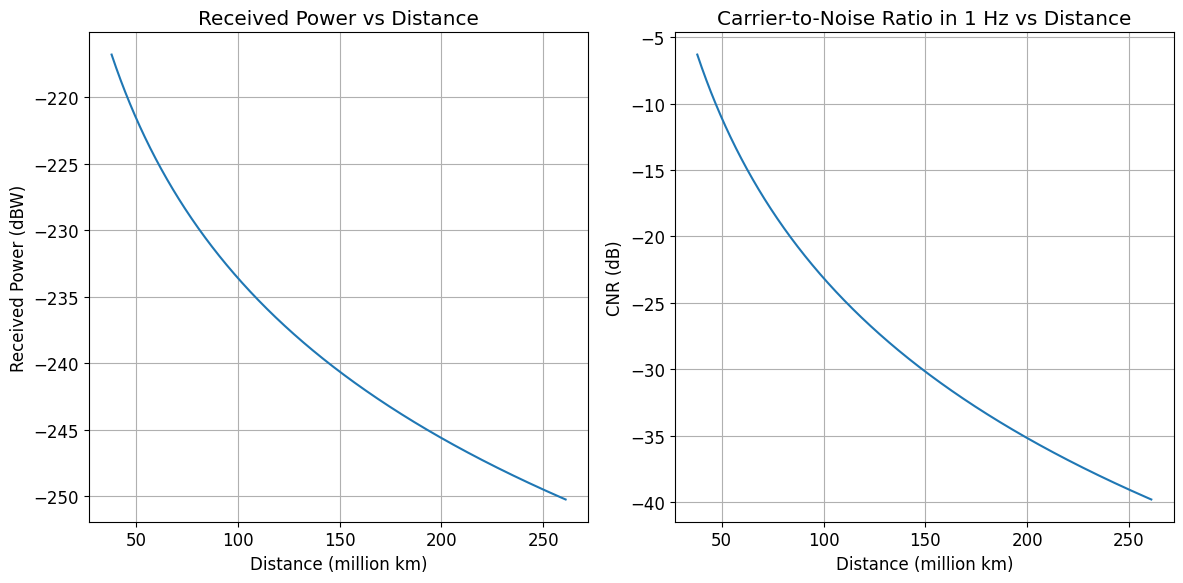

In [86]:
# Create distance array for plotting
distances = np.linspace(min_distance_km, max_distance_km, 1000)
cnrs = []
rx_powers = []

for dist in distances:
    results = calculator.calculate_link_budget(dist)
    cnrs.append(results['cnr_db_1hz'])
    rx_powers.append(results['rx_power_dbw'])

# Cell 4: Create plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(distances/1e6, rx_powers)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('Received Power (dBW)')
plt.title('Received Power vs Distance')

plt.subplot(1, 2, 2)
plt.plot(distances/1e6, cnrs)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('CNR (dB)')
plt.title('Carrier-to-Noise Ratio in 1 Hz vs Distance')
plt.tight_layout()
plt.show()

## Pointing Error Analysis
Dish antennas have a narrow beamwidth, and pointing errors can significantly impact our link budget. This section models pointing errors to determine their impact on signal strength and to include appropriate loss values in our link budget calculations. 

### Visualizations
We provide two visualizations:

1. **Normalized Visualization** (error/beamwidth ratio):
   - Provides a universal reference applicable to any dish size or frequency
   - Illustrates the fundamental relationship between pointing error and beamwidth
   - Demonstrates key principles: 1dB loss occurs at error = beamwidth/5.66, 3dB loss at error = beamwidth/2
   - Facilitates comparisons across different systems!

2. **Absolute Visualization** (error in degrees):
   - Shows practical values specific to our 18.29m dish at 1296 MHz
   - Provides exact specifications for pointing requirements
   - Displays precisely how many degrees of error are acceptable for given loss levels
   - Directly applicable to a specific system's operational planning

You can toggle between these visualizations using the `show_normalized` parameter (True/False).

### Key Calculations Explained
The calculations are based on established antenna theory:

1. **Beamwidth Calculation**:
   - Uses the formula `beamwidth = 1.22 * λ/D` for circular apertures
   - λ is wavelength in meters; D is dish diameter in meters
   - Result is the 3dB beamwidth (where power drops to half)

2. **Pointing Loss Formula**:
   ```
   pointing_loss = -12 * (error_angle / beamwidth)²
   ```
   This quadratic relationship means losses increase rapidly as pointing error grows. 

3. **Critical Error Thresholds**:
   - Working backwards from the formula above we get the following
   - For 1dB loss: error = beamwidth/√12 ≈ beamwidth/5.66
   - For 3dB loss: error = beamwidth/2

For example, with a beamwidth of 0.6°:
- Maximum error for 1dB loss: 0.106° (0.6°/5.66)
- Maximum error for 3dB loss: 0.3° (0.6°/2)

The current system's pointing error (0.01°) is displayed on the graph as a purple dot, showing its position relative to these critical thresholds.

For optimal performance, pointing errors should ideally be kept within 1/10th of the half-power beamwidth. Our system's parameters and visualization help ensure we meet this requirement.

For a 25.0m dish at 1299.0 MHz:
3dB Beamwidth: 0.645 degrees
Maximum pointing error for 1dB loss: 0.114 degrees
Maximum pointing error for 3dB loss: 0.323 degrees
Current system pointing error: 0.010 degrees
Current pointing loss: -0.00 dB
For a 25.0m dish at 1299.0 MHz:
3dB Beamwidth: 0.645 degrees
Maximum pointing error for 1dB loss: 0.114 degrees
Maximum pointing error for 3dB loss: 0.323 degrees
Current system pointing error: 0.010 degrees
Current pointing loss: -0.00 dB


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Pointing Loss vs Error for 25.0m Dish at 1299.0 MHz'}, xlabel='Pointing Error (degrees)', ylabel='Pointing Loss (dB)'>)

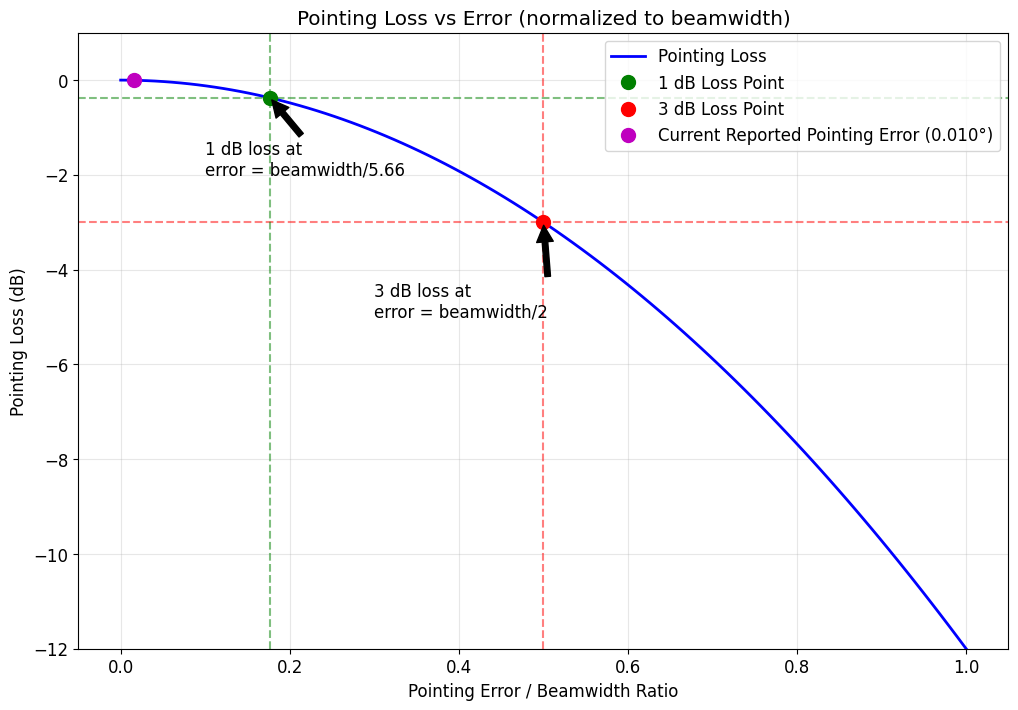

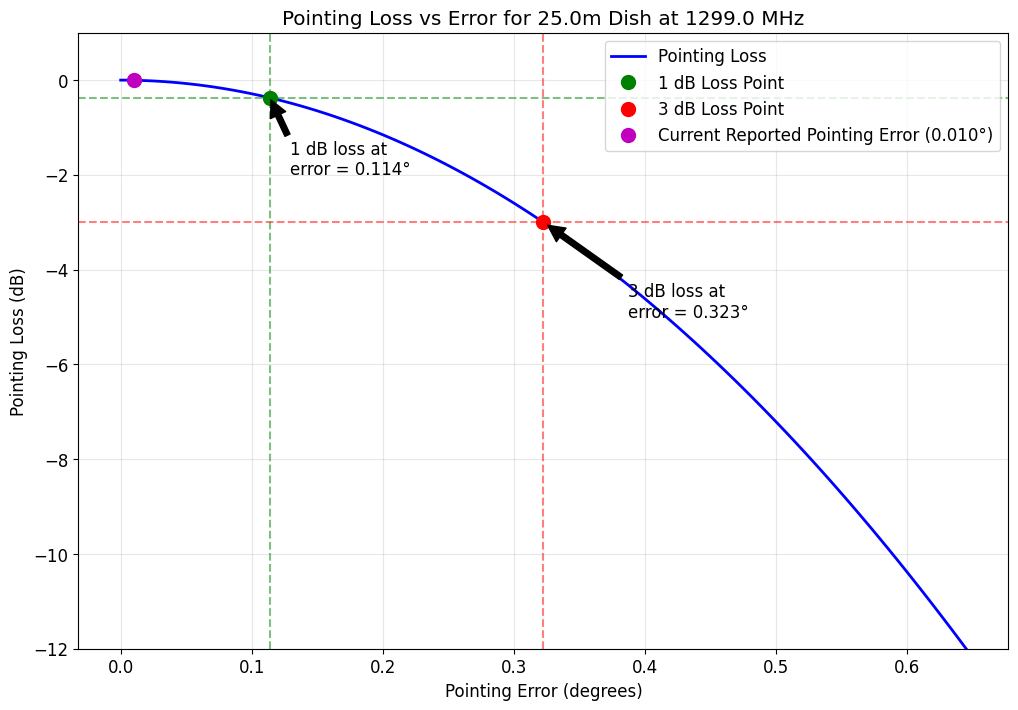

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

class AntennaPointingAnalysis:
    def __init__(self, params: SiteLinkParameters):
        self.params = params
        
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency in MHz"""
        frequency_hz = self.params.tx_frequency_mhz * 1e6  # Convert MHz to Hz
        return self.params.c / frequency_hz
    
    def beamwidth_deg(self) -> float:
        """Calculate 3dB beamwidth in degrees"""
        # Using 1.22 λ/D formula for circular aperture
        return np.degrees(1.22 * self.wavelength() / self.params.tx_antenna_diameter_m)
    
    def calculate_pointing_loss(self, error_angle, beamwidth):
        """Calculate pointing loss in dB given error angle and beamwidth (both in same units)"""
        return -12 * (error_angle / beamwidth)**2
    
    def pointing_loss_analysis(self, max_error_fraction=1.0):
        """Generate pointing loss analysis with normalized and absolute error values"""
        # Get beamwidth
        beamwidth = self.beamwidth_deg()
        
        # Create normalized error fractions (as portion of beamwidth)
        error_fractions = np.linspace(0, max_error_fraction, 100)
        
        # Calculate absolute error values in degrees
        error_degrees = error_fractions * beamwidth
        
        # Calculate losses for the normalized curve
        losses = self.calculate_pointing_loss(error_fractions, 1)
        
        # Calculate key reference points
        loss_at_166 = self.calculate_pointing_loss(1/5.66, 1)  # ~1 dB
        loss_at_half = self.calculate_pointing_loss(1/2, 1)    # ~3 dB
        
        # Current system pointing error and its loss
        current_error = self.params.pointing_error_deg
        current_error_fraction = current_error / beamwidth
        current_loss = self.calculate_pointing_loss(current_error, beamwidth)
        
        # Summary information
        summary = {
            'beamwidth': beamwidth,
            'error_for_1db_loss': beamwidth/5.66,
            'error_for_3db_loss': beamwidth/2,
            'loss_at_166': loss_at_166,
            'loss_at_half': loss_at_half,
            'error_fractions': error_fractions,
            'error_degrees': error_degrees,
            'losses': losses,
            'current_error': current_error,
            'current_error_fraction': current_error_fraction,
            'current_loss': current_loss
        }
        
        return summary
    
    def plot_pointing_loss(self, show_normalized=True):
        """Create comprehensive pointing loss visualization"""
        # Get analysis data
        data = self.pointing_loss_analysis(max_error_fraction=1.0)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        if show_normalized:
            # Plot normalized curve (error as fraction of beamwidth)
            ax.plot(data['error_fractions'], data['losses'], 'b-', linewidth=2, label='Pointing Loss')
            
            # Add markers for specific loss points
            ax.plot(1/5.66, data['loss_at_166'], 'go', markersize=10, label='1 dB Loss Point')
            ax.plot(1/2, data['loss_at_half'], 'ro', markersize=10, label='3 dB Loss Point')
            
            # Add point for current system pointing error
            ax.plot(data['current_error_fraction'], data['current_loss'], 'mo', 
                    markersize=10, label='Current Reported Pointing Error (%.3f°)' % data['current_error'])
            
            # Add horizontal and vertical reference lines
            ax.axhline(y=data['loss_at_166'], color='g', linestyle='--', alpha=0.5)
            ax.axhline(y=data['loss_at_half'], color='r', linestyle='--', alpha=0.5)
            ax.axvline(x=1/5.66, color='g', linestyle='--', alpha=0.5)
            ax.axvline(x=1/2, color='r', linestyle='--', alpha=0.5)
            
            # Add annotations
            ax.annotate('1 dB loss at\nerror = beamwidth/5.66', 
                        xy=(1/5.66, data['loss_at_166']), xytext=(0.1, -2),
                        arrowprops=dict(facecolor='black', shrink=0.05))
            ax.annotate('3 dB loss at\nerror = beamwidth/2', 
                        xy=(1/2, data['loss_at_half']), xytext=(0.3, -5),
                        arrowprops=dict(facecolor='black', shrink=0.05))
            
            # Set axis labels
            ax.set_xlabel('Pointing Error / Beamwidth Ratio')
            title = 'Pointing Loss vs Error (normalized to beamwidth)'
        else:
            # Plot absolute curve (error in degrees)
            ax.plot(data['error_degrees'], data['losses'], 'b-', linewidth=2, label='Pointing Loss')
            
            # Add markers for specific loss points
            ax.plot(data['error_for_1db_loss'], data['loss_at_166'], 'go', markersize=10, label='1 dB Loss Point')
            ax.plot(data['error_for_3db_loss'], data['loss_at_half'], 'ro', markersize=10, label='3 dB Loss Point')
            
            # Add point for current system pointing error
            ax.plot(data['current_error'], data['current_loss'], 'mo', 
                    markersize=10, label='Current Reported Pointing Error (%.3f°)' % data['current_error'])
            
            # Add horizontal and vertical reference lines
            ax.axhline(y=data['loss_at_166'], color='g', linestyle='--', alpha=0.5)
            ax.axhline(y=data['loss_at_half'], color='r', linestyle='--', alpha=0.5)
            ax.axvline(x=data['error_for_1db_loss'], color='g', linestyle='--', alpha=0.5)
            ax.axvline(x=data['error_for_3db_loss'], color='r', linestyle='--', alpha=0.5)
            
            # Add annotations
            ax.annotate(f'1 dB loss at\nerror = {data["error_for_1db_loss"]:.3f}°', 
                        xy=(data['error_for_1db_loss'], data['loss_at_166']), 
                        xytext=(data['beamwidth']*0.2, -2),
                        arrowprops=dict(facecolor='black', shrink=0.05))
            ax.annotate(f'3 dB loss at\nerror = {data["error_for_3db_loss"]:.3f}°', 
                        xy=(data['error_for_3db_loss'], data['loss_at_half']), 
                        xytext=(data['beamwidth']*0.6, -5),
                        arrowprops=dict(facecolor='black', shrink=0.05))
            
            # Set axis labels
            ax.set_xlabel('Pointing Error (degrees)')
            title = f'Pointing Loss vs Error for {self.params.tx_antenna_diameter_m:.1f}m Dish at {self.params.tx_frequency_mhz:.1f} MHz'
        

        # Get current loss value to adjust y-limits if needed
        current_loss = data['current_loss']
        
        # Calculate appropriate y-limits
        # Start with default range
        y_min = -12
        y_max = 0.5  # Give a bit more space at the top
        
        # Adjust if current loss is very close to zero
        if current_loss > -0.5:
            y_max = 1  # Give even more space at the top
            
        # Common formatting
        ax.set_ylabel('Pointing Loss (dB)')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)  # Use the calculated limits
        ax.legend()


        # Print summary information
        print(f"For a {self.params.tx_antenna_diameter_m:.1f}m dish at {self.params.tx_frequency_mhz:.1f} MHz:")
        print(f"3dB Beamwidth: {data['beamwidth']:.3f} degrees")
        print(f"Maximum pointing error for 1dB loss: {data['error_for_1db_loss']:.3f} degrees") 
        print(f"Maximum pointing error for 3dB loss: {data['error_for_3db_loss']:.3f} degrees")
        print(f"Current system pointing error: {data['current_error']:.3f} degrees")
        print(f"Current pointing loss: {data['current_loss']:.2f} dB")
        
        return fig, ax

# Set up the calculator
params = SiteLinkParameters()
analyzer = AntennaPointingAnalysis(params)
# 
# # Show normalized plot (relative to beamwidth)
analyzer.plot_pointing_loss(show_normalized=True)
# 
# # Show absolute plot (in degrees)
analyzer.plot_pointing_loss(show_normalized=False)

## How much Doppler do we Have?

We will have to anticipate and "track out" Doppler and understand and tolerate a rate of change of this Doppler shift. A third factor is Doppler spread, which is what happens when a signal bounces off a rotating reflector. 

A Doppler spread penalty calculation is currently in the Mode Evaluator cell. 

How much Doppler do we have to deal with? This section calculates Doppler shift and the rate of change of the Doppler shift, and visualizes the results. 


-------------------------------------------------------------
From Center-of-the-Earth Doppler calculations
-------------------------------------------------------------
Calculating Doppler for current time: 2025-03-19 01:44:44.736582+00:00
Current Earth-Venus:
  Relative velocity: -1829.91 m/s
  Doppler shift: 7928.98 Hz
  Received frequency: 1299.007929 MHz

Doppler shift rate of change (next 24 hours):
  Rate: -91.20 Hz/hour or -0.0253 Hz/second
  Starting Doppler: 7928.98 Hz
  Ending Doppler: 5740.21 Hz
  Total change: -2188.78 Hz

Calculating worst-case Doppler scenarios for a complete orbit cycle...
Worst-case Doppler shift:
  Maximum (positive) shift: 60103.92 Hz on 2026-08-04 07:44:44.744190+00:00
  Minimum (negative) shift: -60282.48 Hz on 2025-06-03 07:44:44.744190+00:00
  Total Doppler range: 120386.39 Hz

Worst-case Doppler rate of change:
  Maximum rate: -92.96 Hz/hour or -0.025823 Hz/second
  Occurs on: 2025-03-22 19:44:44.744190+00:00

----------------------------------

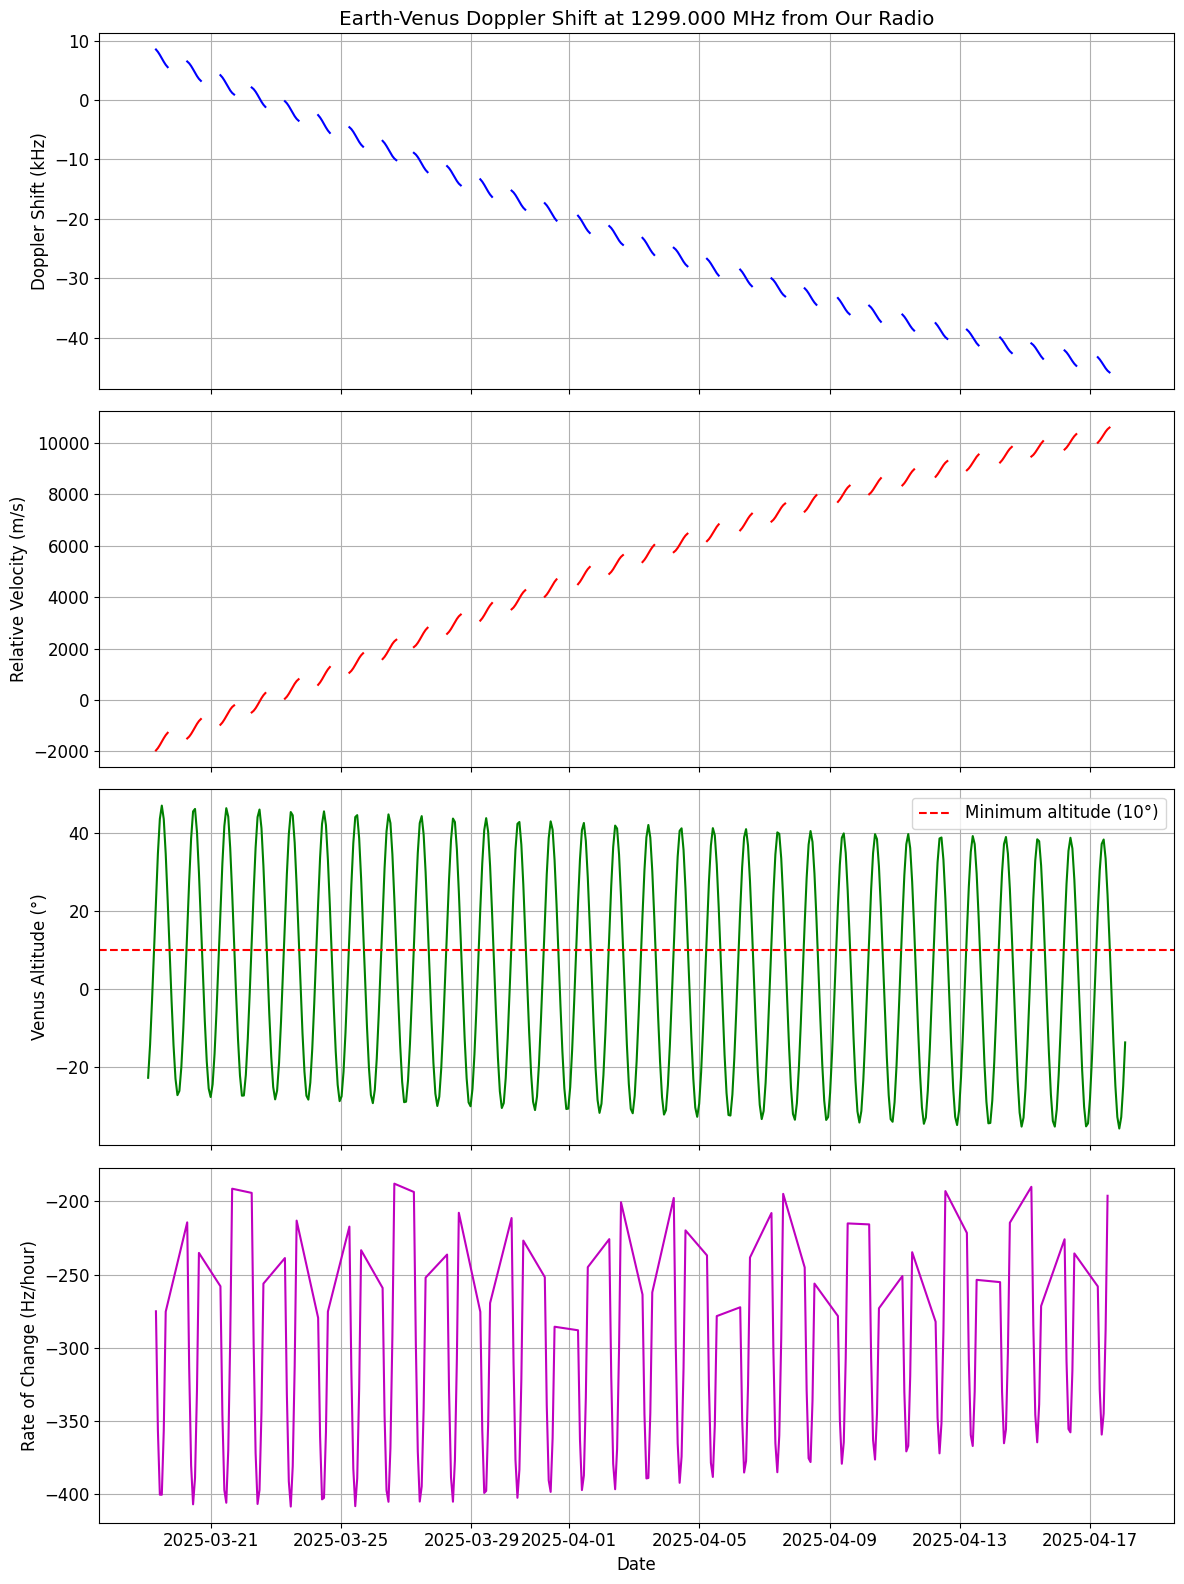


Setting location to London (51.5074°, -0.1278°)
Current Earth-Venus from London:
  Venus altitude: -25.82° / azimuth: 23.83°
  Relative velocity: -1934.77 m/s
  Doppler shift: 8383.34 Hz
  Received frequency: 1299.008383 MHz
  Venus is not visible (assuming min altitude of 10°)

  Calculating worst-case scenarios for London over next 30 days...
  Maximum visible altitude: 48.11° on 2025-03-19 12:32:47.002557+00:00
  Venus visibility: 41.5% of time
  Maximum Doppler shift: 8697.67 Hz
  Minimum Doppler shift: -45851.33 Hz
  Maximum rate of change: -419.58 Hz/hour or -0.116551 Hz/second


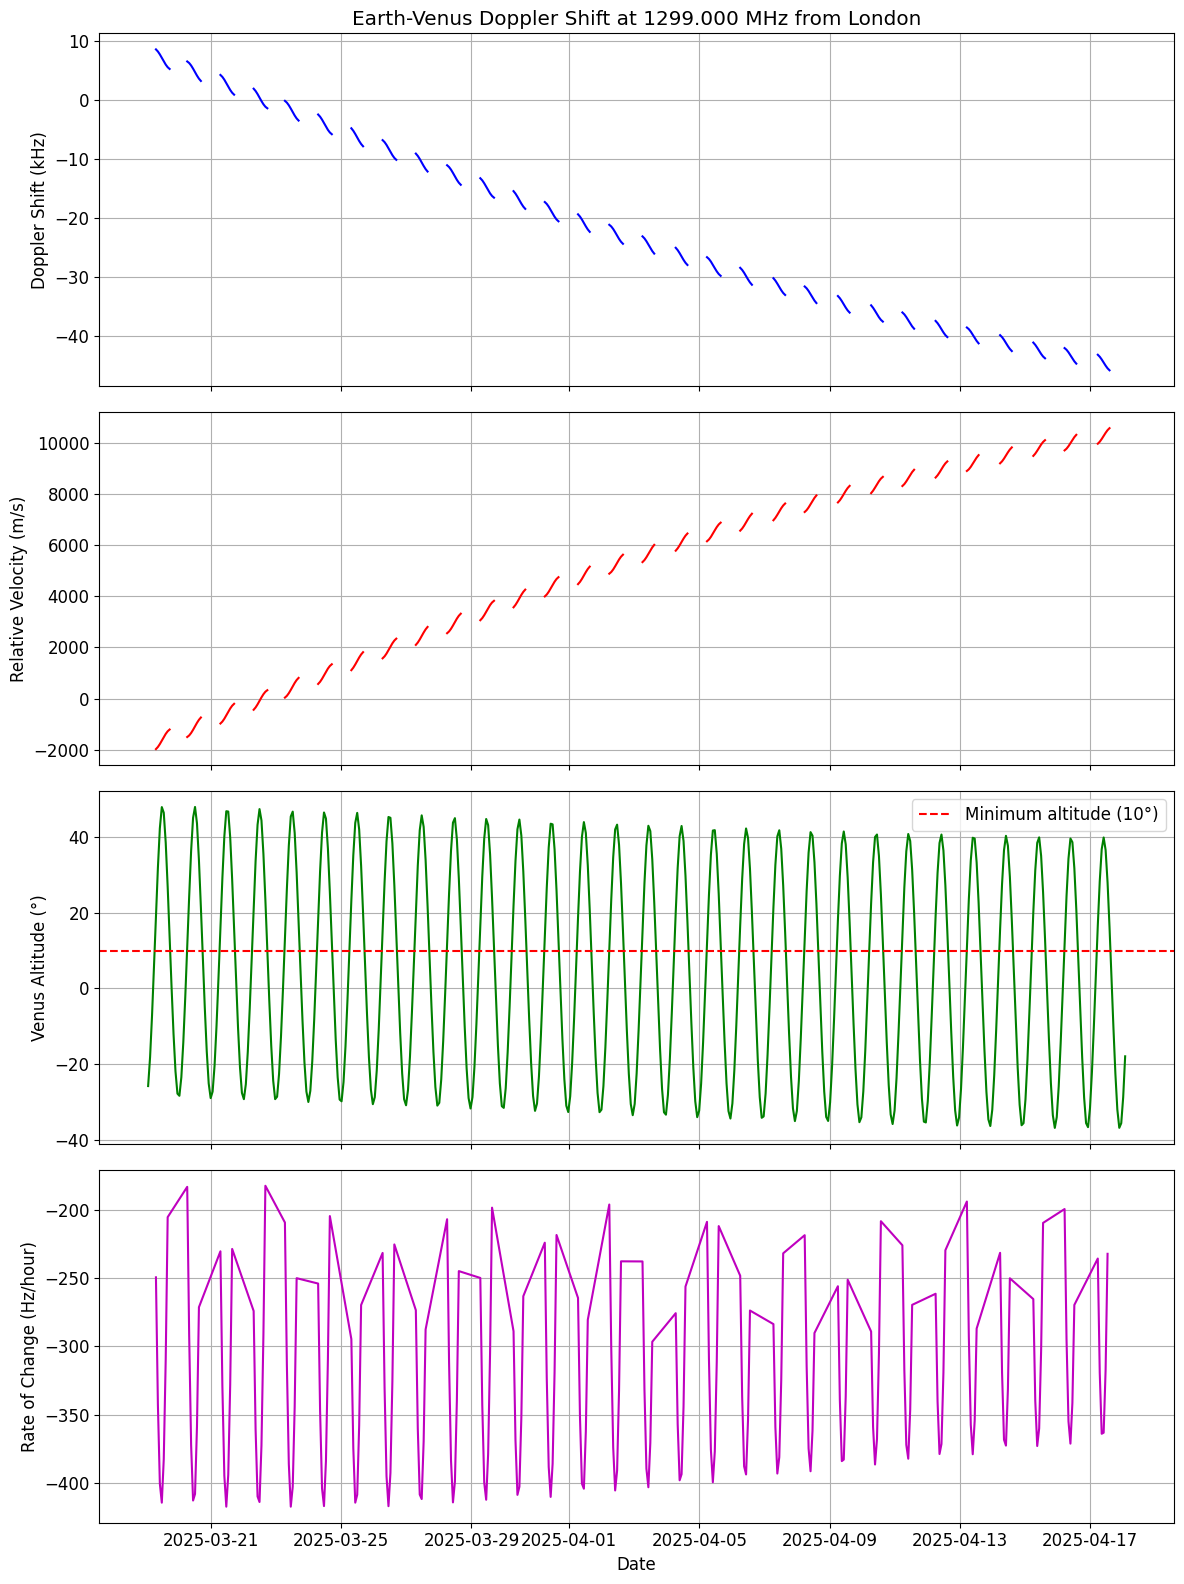


Setting location to Sidney (-33.8688°, 151.2093°)
Current Earth-Venus from Sidney:
  Venus altitude: 45.74° / azimuth: 9.91°
  Relative velocity: -1876.13 m/s
  Doppler shift: 8129.26 Hz
  Received frequency: 1299.008129 MHz
  Venus is visible (assuming min altitude of 10°)

  Calculating worst-case scenarios for Sidney over next 30 days...
  Maximum visible altitude: 54.71° on 2025-04-17 23:35:12.285841+00:00
  Venus visibility: 38.6% of time
  Maximum Doppler shift: 8128.74 Hz
  Minimum Doppler shift: -46013.02 Hz
  Maximum rate of change: -528.34 Hz/hour or -0.146761 Hz/second


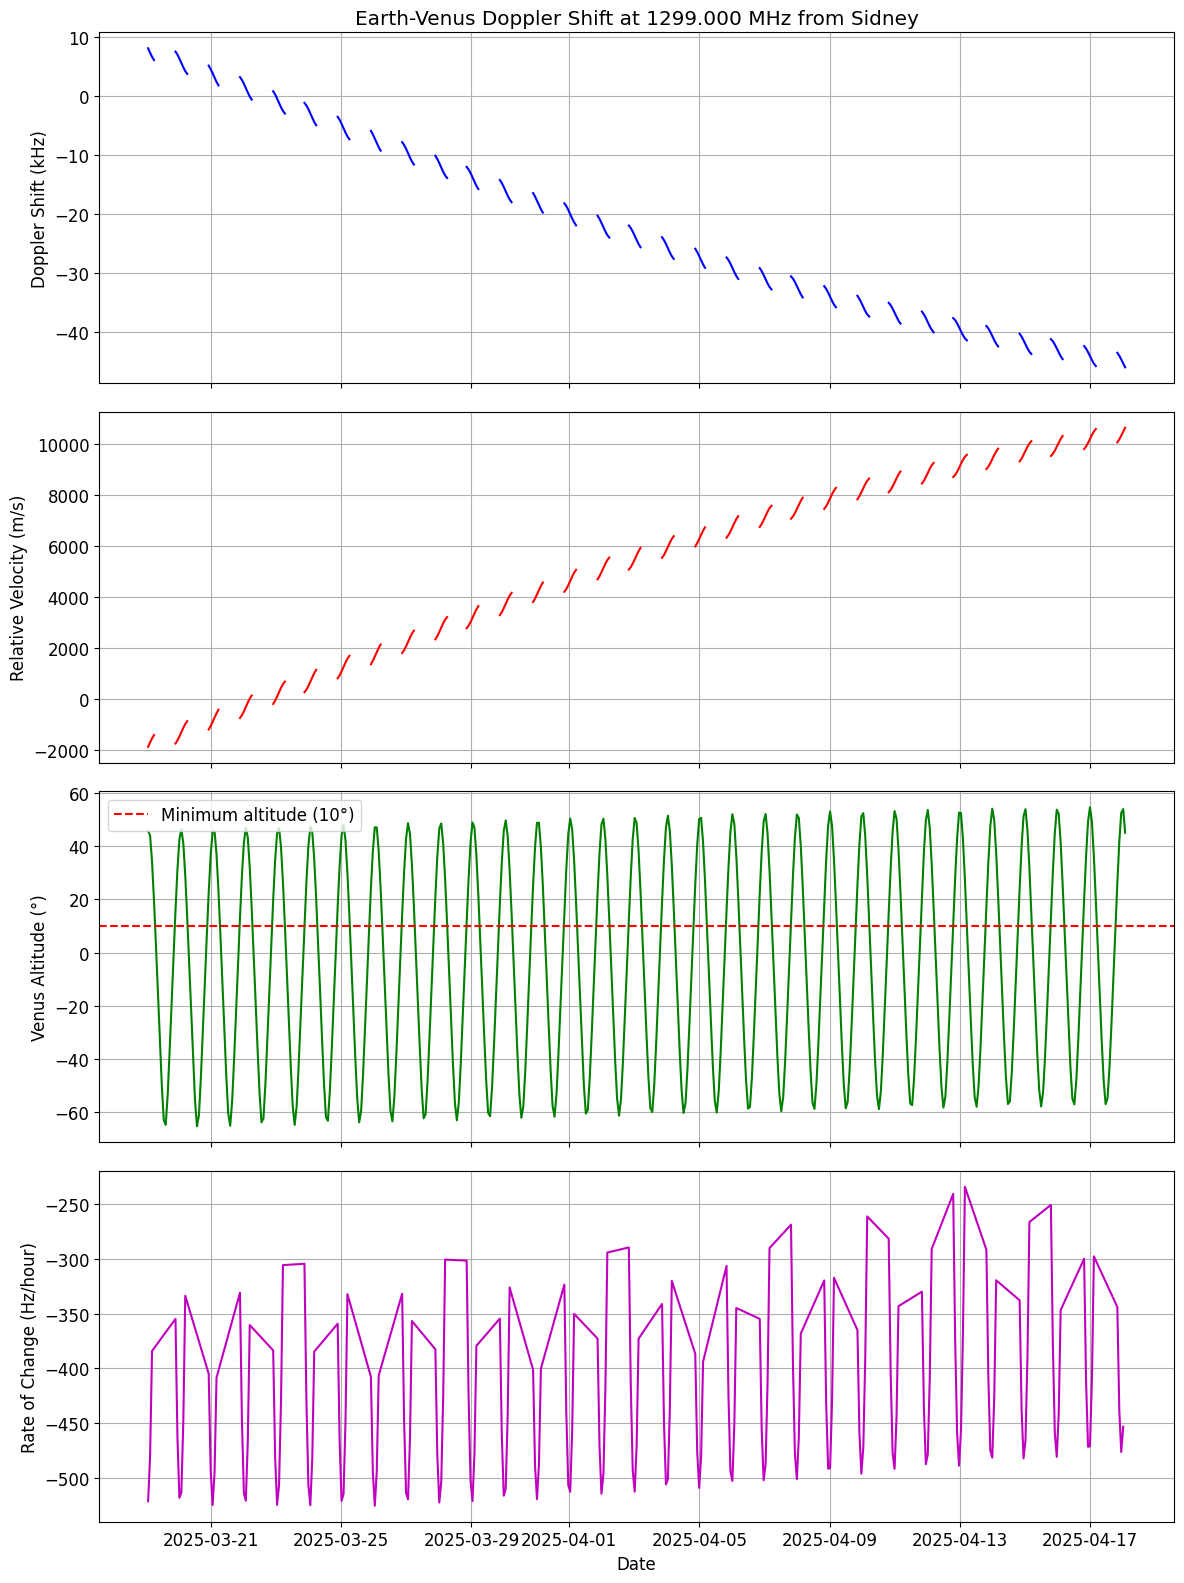


Generating center-of-Earth Doppler curve from 2025-03-19 01:44:49.561262+00:00 to 2025-04-18 01:44:49.561262+00:00


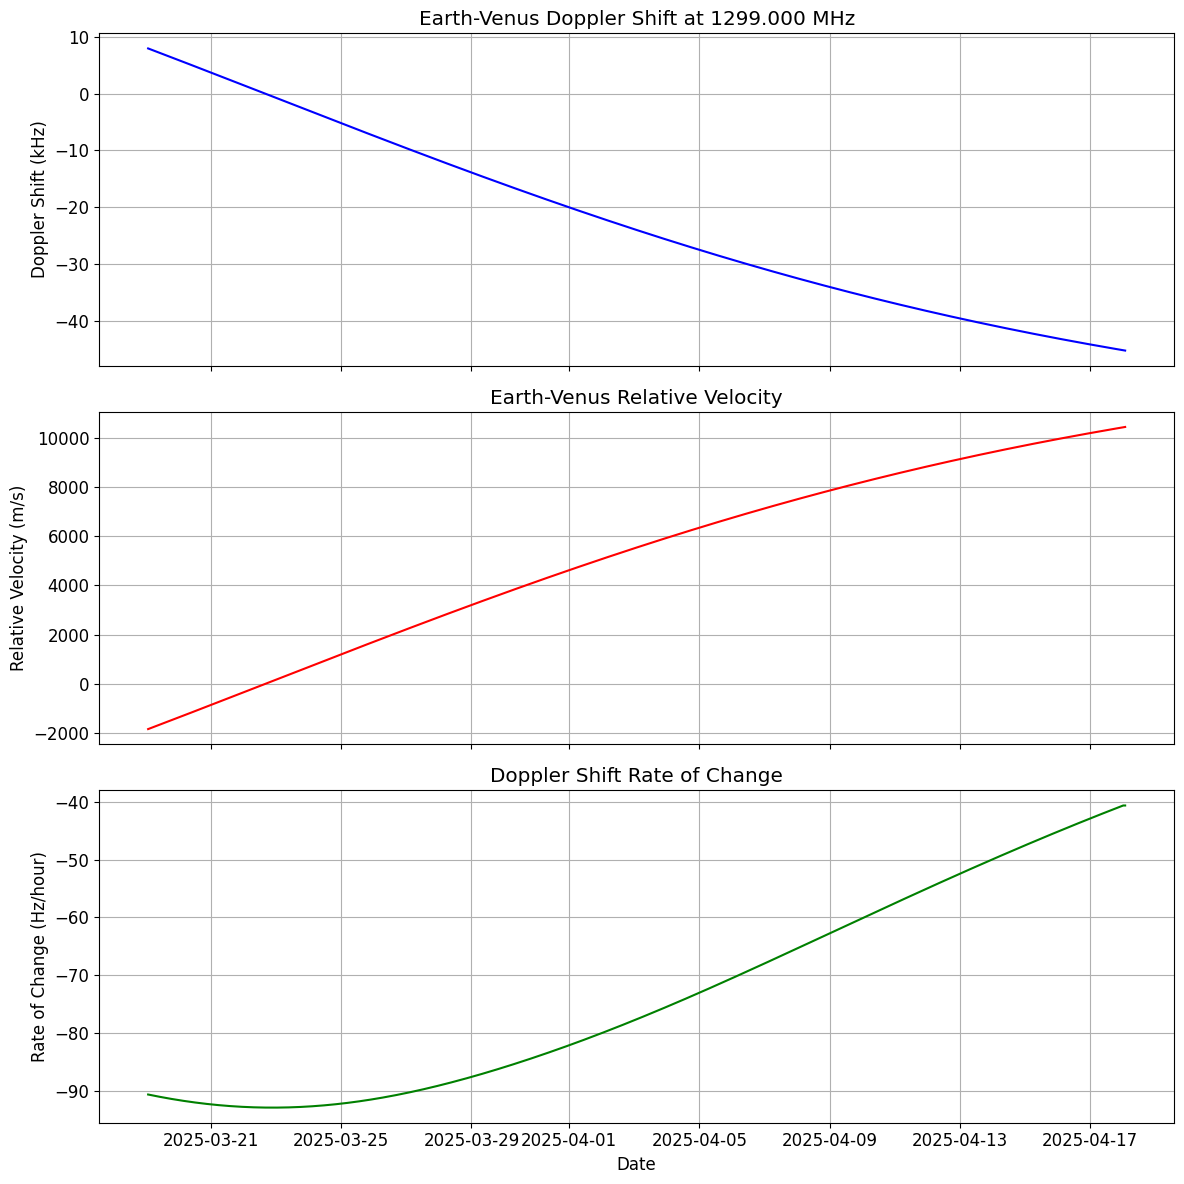

In [88]:
#import numpy as np
#from skyfield.api import load, wgs84
#from datetime import datetime, timedelta, timezone
#import matplotlib.pyplot as plt

class DopplerCalculator:
    """
    A class to calculate Doppler shift between Earth and Venus.
    
    This class uses the Skyfield library to obtain planetary ephemeris data
    from publicly available sources and calculate the relative velocity and
    resulting Doppler shift and shift rate for radio communications.
    """
    
    def __init__(self, params: SiteLinkParameters):
        self.params = params
        """
        Initialize the Doppler calculator with one of our site-specific dataclasses.
        
        Parameters:
        -----------
        tx_frequency_mhz : float from <site>LinkParameters
            The transmission frequency in MHz (eg. 1296.0 MHz)
        """

        # Convert MHz to Hz for calculations
        self.frequency_hz = self.params.tx_frequency_mhz * 1e6
        
        # Load ephemeris data
        self.ephemeris = load('de421.bsp')
        self.earth = self.ephemeris['earth']
        self.venus = self.ephemeris['venus']
        
        # Time scale
        self.ts = load.timescale()
        
        # Observer location (initially None)
        self.has_observer = False
    
    def set_frequency(self, frequency_mhz):
        """
        Update the transmission frequency, outside of the dataclass.
        
        Parameters:
        -----------
        frequency_mhz : float
            The new transmission frequency in MHz
        """
        self.frequency_hz = frequency_mhz * 1e6
    
    def calculate_doppler(self, timestamp=None):
        """
        Calculate the Doppler shift at a specific time.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time at which to calculate the Doppler shift (default: current time)
            If timezone-naive, UTC will be used
            
        Returns:
        --------
        tuple:
            - Frequency shift in Hz
            - Received frequency in Hz
            - Relative velocity in m/s (positive: moving apart, negative: moving closer)
        """
        if timestamp is None:
            # Make sure we use timezone-aware UTC time
            timestamp = datetime.now(timezone.utc)
        elif timestamp.tzinfo is None:
            # If the timestamp is naive (no timezone), assume it's in UTC
            timestamp = timestamp.replace(tzinfo=timezone.utc)
        
        # Convert to Skyfield time. This is called a "decomposed" approach
        t = self.ts.utc(timestamp.year, timestamp.month, timestamp.day,
                        timestamp.hour, timestamp.minute, timestamp.second + timestamp.microsecond/1000000.0)
        
        # Get the position and velocity vectors
        earth_pos = self.earth.at(t)
        venus_pos = self.venus.at(t)
        
        # Calculate relative position and velocity
        relative = earth_pos.observe(self.venus)
        distance = relative.distance().km
        relative_velocity = relative.velocity.km_per_s
        
        # The radial velocity component (positive means moving apart)
        radial_velocity = np.dot(relative_velocity, relative.position.km / distance)
        
        # Convert km/s to m/s
        radial_velocity_m_s = radial_velocity * 1000
        
        # Calculate Doppler shift
        # If objects are moving apart (positive velocity), frequency decreases
        doppler_shift = -self.frequency_hz * radial_velocity_m_s / self.params.c
        received_frequency = self.frequency_hz + doppler_shift
        
        return doppler_shift, received_frequency, radial_velocity_m_s
    
    def calculate_doppler_rate(self, timestamp=None, delta_hours=24):
        """
        Calculate the rate of change of the Doppler shift over a specified time period.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time at which to start the calculation (default: current time)
            If timezone-naive, UTC will be assumed
        delta_hours : float, optional
            The time period in hours over which to calculate the rate (default: 24 hours)
            
        Returns:
        --------
        tuple:
            - Rate of Doppler shift change in Hz/hour
            - Rate of Doppler shift change in Hz/second
            - Doppler shift at start time in Hz
            - Doppler shift at end time in Hz
        """
        if timestamp is None:
            timestamp = datetime.now(timezone.utc)
        elif timestamp.tzinfo is None:
            timestamp = timestamp.replace(tzinfo=timezone.utc)
        
        # Calculate Doppler shift at the start time
        doppler_start, _, _ = self.calculate_doppler(timestamp)
        
        # Calculate Doppler shift at the end time
        end_time = timestamp + timedelta(hours=delta_hours)
        doppler_end, _, _ = self.calculate_doppler(end_time)
        
        # Calculate the rate of change
        delta_doppler = doppler_end - doppler_start
        rate_per_hour = delta_doppler / delta_hours
        rate_per_second = rate_per_hour / 3600
        
        return rate_per_hour, rate_per_second, doppler_start, doppler_end
    
    def generate_doppler_curve(self, start_date, end_date, num_points=100):
        """
        Generate a curve of Doppler shift over a time period.
        
        Parameters:
        -----------
        start_date : datetime
            The starting date for the curve (if timezone-naive, UTC will be assumed)
        end_date : datetime
            The ending date for the curve (if timezone-naive, UTC will be assumed)
        num_points : int, optional
            Number of points to calculate (default: 100)
            
        Returns:
        --------
        tuple:
            - List of datetime objects
            - List of Doppler shifts in Hz
            - List of relative velocities in m/s
        """
        # Ensure both dates have timezone information
        if start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        if end_date.tzinfo is None:
            end_date = end_date.replace(tzinfo=timezone.utc)
        
        time_delta = (end_date - start_date) / num_points
        
        times = []
        doppler_shifts = []
        velocities = []
        
        for i in range(num_points + 1):
            current_time = start_date + i * time_delta
            try:
                doppler_shift, _, velocity = self.calculate_doppler(current_time)
                
                times.append(current_time)
                doppler_shifts.append(doppler_shift)
                velocities.append(velocity)
            except Exception as e:
                print(f"Error calculating Doppler at time {current_time}: {e}")
                # Continue with the loop but skip this problematic point
                continue
        
        return times, doppler_shifts, velocities
    
    def calculate_worst_case_doppler(self, start_date=None, duration_days=584):
        """
        Calculate the worst-case Doppler shift and rate of change over a complete synodic period.
        
        The synodic period of Venus is approximately 584 days (the time it takes for Earth
        and Venus to return to the same relative positions).
        
        Parameters:
        -----------
        start_date : datetime, optional
            The starting date for the analysis (default: current time)
        duration_days : int, optional
            The duration in days to analyze (default: 584, one synodic period)
            
        Returns:
        --------
        dict:
            Dictionary containing:
            - max_doppler_shift: Maximum absolute Doppler shift in Hz
            - min_doppler_shift: Minimum Doppler shift in Hz (most negative)
            - max_doppler_shift_date: Date of maximum Doppler shift
            - min_doppler_shift_date: Date of minimum Doppler shift
            - max_rate: Maximum absolute rate of change in Hz/hour
            - max_rate_date: Date of maximum rate of change
            - max_rate_per_second: Maximum rate in Hz/second
            - total_doppler_range: Total range of Doppler shift in Hz
        """
        if start_date is None:
            start_date = datetime.now(timezone.utc)
        elif start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        
        end_date = start_date + timedelta(days=duration_days)
        
        # Use enough points to get good resolution (at least one point per day)
        num_points = max(1000, duration_days * 4)
        
        times, shifts, velocities = self.generate_doppler_curve(start_date, end_date, num_points)
        
        # Calculate rates of change
        rates = []
        rate_times = []
        
        for i in range(len(shifts) - 1):
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
            rate_times.append(times[i])
        
        # Find extremes for Doppler shift
        max_shift_idx = np.argmax(shifts)
        min_shift_idx = np.argmin(shifts)
        max_shift = shifts[max_shift_idx]
        min_shift = shifts[min_shift_idx]
        max_shift_date = times[max_shift_idx]
        min_shift_date = times[min_shift_idx]
        
        # Find extreme for rate of change (maximum absolute value)
        abs_rates = np.abs(rates)
        max_rate_idx = np.argmax(abs_rates)
        max_rate = rates[max_rate_idx]
        max_rate_date = rate_times[max_rate_idx]
        max_rate_per_second = max_rate / 3600
        
        # Calculate total Doppler range
        total_doppler_range = max_shift - min_shift
        
        return {
            'max_doppler_shift': max_shift,
            'min_doppler_shift': min_shift,
            'max_doppler_shift_date': max_shift_date,
            'min_doppler_shift_date': min_shift_date,
            'max_rate': max_rate,
            'max_rate_date': max_rate_date,
            'max_rate_per_second': max_rate_per_second,
            'total_doppler_range': total_doppler_range
        }
    
    def plot_doppler_curve(self, start_date, end_date, num_points=100, save_path=None, include_rate=True):
        """
        Generate and plot a curve of Doppler shift over a time period.
        
        Parameters:
        -----------
        start_date : datetime
            The starting date for the curve
        end_date : datetime
            The ending date for the curve
        num_points : int, optional
            Number of points to calculate (default: 100)
        save_path : str, optional
            Path to save the plot (default: None, plot is displayed instead)
        include_rate : bool, optional
            Whether to include a subplot showing the rate of change (default: True)
        """
        times, shifts, velocities = self.generate_doppler_curve(start_date, end_date, num_points)
        
        # Calculate rate of change for each point except the last one
        rates = []
        for i in range(len(shifts) - 1):
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
        
        # Add a placeholder for the last point to keep the arrays the same length
        rates.append(rates[-1] if rates else 0)  
        
        # Determine the number of subplots
        n_plots = 3 if include_rate else 2
        
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots), sharex=True)
        
        # Plot Doppler shift
        axes[0].plot(times, [s/1000 for s in shifts], 'b-')
        axes[0].set_ylabel('Doppler Shift (kHz)')
        axes[0].set_title(f'Earth-Venus Doppler Shift at {self.frequency_hz/1e6:.3f} MHz')
        axes[0].grid(True)
        
        # Plot velocity
        axes[1].plot(times, velocities, 'r-')
        axes[1].set_ylabel('Relative Velocity (m/s)')
        axes[1].set_title('Earth-Venus Relative Velocity')
        axes[1].grid(True)
        
        # Plot rate of change if requested
        if include_rate:
            axes[2].plot(times, rates, 'g-')
            axes[2].set_xlabel('Date')
            axes[2].set_ylabel('Rate of Change (Hz/hour)')
            axes[2].set_title('Doppler Shift Rate of Change')
            axes[2].grid(True)
        else:
            axes[1].set_xlabel('Date')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()


    # fixed this with a lot of help - it wasn't updating past the first location
    def set_observer_location(self, latitude, longitude, elevation=0, location_name=None):
            """
            Set the Earth-based observer's location.
            
            Parameters:
            -----------
            latitude : float
                Observer's latitude in degrees (positive for north, negative for south)
            longitude : float
                Observer's longitude in degrees (positive for east, negative for west)
            elevation : float, optional
                Observer's elevation above sea level in meters (default: 0)
            location_name : str, optional
                Name of the location (e.g., 'Site 1', 'New York', etc.)
            """
            # Create a completely new observer_location object EVERY time
            self.observer_location = None  # Clear the old one first
            self.observer_location = wgs84.latlon(latitude, longitude, elevation_m=elevation)
            self.has_observer = True
            self.location_name = location_name if location_name else f"({latitude:.2f}°, {longitude:.2f}°)"
            
            # Force the location to be recreated the next time it's used
            if hasattr(self, '_location_object'):
                del self._location_object

    
    def calculate_doppler_from_location(self, timestamp=None):
        """
        Calculate the Doppler shift at a specific time from the observer's location.
        This includes the additional effect of Earth's rotation.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time at which to calculate the Doppler shift (default: current time)
            If timezone-naive, UTC will be assumed
            
        Returns:
        --------
        tuple:
            - Frequency shift in Hz
            - Received frequency in Hz
            - Relative velocity in m/s
            - Venus altitude in degrees (for visibility determination)
            - Venus azimuth in degrees
        """
        if not self.has_observer:
            raise ValueError("Observer location not set. Use set_observer_location() first.")
        
        if timestamp is None:
            timestamp = datetime.now(timezone.utc)
        elif timestamp.tzinfo is None:
            timestamp = timestamp.replace(tzinfo=timezone.utc)
        
        # Convert to Skyfield time
        t = self.ts.utc(timestamp.year, timestamp.month, timestamp.day,
                        timestamp.hour, timestamp.minute, timestamp.second + timestamp.microsecond/1000000.0)
        
        # Create a Skyfield location object for the observer
        location = self.earth + self.observer_location
        
        # Get topocentric position (from observer's location)
        venus_apparent = location.at(t).observe(self.venus).apparent()
        
        # Get altitude and azimuth for visibility determination
        alt, az, distance = venus_apparent.altaz()
        
        # Get the velocity component
        relative_velocity = venus_apparent.velocity.km_per_s
        
        # The radial velocity component (positive means moving apart)
        radial_velocity = np.dot(relative_velocity, venus_apparent.position.km / venus_apparent.distance().km)
        
        # Convert km/s to m/s
        radial_velocity_m_s = radial_velocity * 1000
        
        # Calculate Doppler shift
        doppler_shift = -self.frequency_hz * radial_velocity_m_s / self.params.c
        received_frequency = self.frequency_hz + doppler_shift
        
        return doppler_shift, received_frequency, radial_velocity_m_s, alt.degrees, az.degrees
    
    def is_visible_from_location(self, timestamp=None, min_altitude=10):
        """
        Determine if Venus is visible from the observer's location.
        
        Parameters:
        -----------
        timestamp : datetime, optional
            The time to check visibility (default: current time)
        min_altitude : float, optional
            Minimum altitude in degrees for visibility (default: 10)
            
        Returns:
        --------
        bool:
            True if Venus is above the minimum altitude, False otherwise
        """
        if not self.has_observer:
            raise ValueError("Observer location not set. Use set_observer_location() first.")
        
        _, _, _, altitude, _ = self.calculate_doppler_from_location(timestamp)
        return altitude > min_altitude
    
    def generate_location_doppler_curve(self, start_date, end_date, num_points=100, 
                                      include_visibility=True, min_altitude=10):
        """
        Generate a curve of Doppler shift from the observer's location over a time period.
        
        Parameters:
        -----------
        start_date, end_date : datetime
            The time range to generate the curve for
        num_points : int, optional
            Number of points to calculate (default: 100)
        include_visibility : bool, optional
            Whether to mask points where Venus is not visible (default: True)
        min_altitude : float, optional
            Minimum altitude in degrees for visibility (default: 10)
            
        Returns:
        --------
        tuple:
            - List of datetime objects
            - List of Doppler shifts in Hz
            - List of relative velocities in m/s
            - List of Venus altitudes in degrees
            - List of visibility flags
        """
        if not self.has_observer:
            raise ValueError("Observer location not set. Use set_observer_location() first.")
        
        # Ensure both dates have timezone information
        if start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        if end_date.tzinfo is None:
            end_date = end_date.replace(tzinfo=timezone.utc)
        
        time_delta = (end_date - start_date) / num_points
        
        times = []
        doppler_shifts = []
        velocities = []
        altitudes = []
        visibilities = []
        
        for i in range(num_points + 1):
            current_time = start_date + i * time_delta
            try:
                doppler_shift, _, velocity, alt, _ = self.calculate_doppler_from_location(current_time)
                is_visible = alt > min_altitude
                
                times.append(current_time)
                doppler_shifts.append(doppler_shift)
                velocities.append(velocity)
                altitudes.append(alt)
                visibilities.append(is_visible)
            except Exception as e:
                print(f"Error calculating Doppler at time {current_time}: {e}")
                continue
        
        # If including visibility, mask points where Venus is not visible
        if include_visibility:
            masked_shifts = []
            masked_velocities = []
            for i in range(len(visibilities)):
                if not visibilities[i]:
                    # Set to None to create gaps in the plot
                    masked_shifts.append(None)
                    masked_velocities.append(None)
                else:
                    masked_shifts.append(doppler_shifts[i])
                    masked_velocities.append(velocities[i])
            doppler_shifts = masked_shifts
            velocities = masked_velocities
        
        return times, doppler_shifts, velocities, altitudes, visibilities
    
    def plot_location_doppler_curve(self, start_date, end_date, num_points=100, 
                                  save_path=None, include_visibility=True, min_altitude=10):
        """
        Generate and plot a curve of Doppler shift from the observer's location.
        
        Parameters:
        -----------
        start_date, end_date : datetime
            The time range to generate the curve for
        num_points : int, optional
            Number of points to calculate (default: 100)
        save_path : str, optional
            Path to save the plot (default: None, plot is displayed instead)
        include_visibility : bool, optional
            Whether to mask points where Venus is not visible (default: True)
        min_altitude : float, optional
            Minimum altitude in degrees for visibility (default: 10)
        """
        if not self.has_observer:
            raise ValueError("Observer location not set. Use set_observer_location() first.")
        
        times, shifts, velocities, altitudes, visibilities = \
            self.generate_location_doppler_curve(start_date, end_date, num_points, 
                                              include_visibility, min_altitude)
        
        # Calculate rates of change
        rates = []
        rate_times = []
        
        for i in range(len(shifts) - 1):
            # Skip None values (when Venus is not visible)
            if shifts[i] is None or shifts[i+1] is None:
                continue
                
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
            rate_times.append(times[i])
        
        # Create subplots: Doppler, Velocity, Altitude, Rate
        fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
        
        # Plot Doppler shift
        axes[0].plot(times, [s/1000 if s is not None else None for s in shifts], 'b-')
        axes[0].set_ylabel('Doppler Shift (kHz)')
        axes[0].set_title(f'Earth-Venus Doppler Shift at {self.frequency_hz/1e6:.3f} MHz from {self.location_name}')
        axes[0].grid(True)
        
        # Plot velocity
        axes[1].plot(times, velocities, 'r-')
        axes[1].set_ylabel('Relative Velocity (m/s)')
        axes[1].grid(True)
        
        # Plot altitude
        axes[2].plot(times, altitudes, 'g-')
        axes[2].set_ylabel('Venus Altitude (°)')
        if include_visibility:
            axes[2].axhline(y=min_altitude, color='r', linestyle='--', 
                          label=f'Minimum altitude ({min_altitude}°)')
            axes[2].legend()
        axes[2].grid(True)
        
        # Plot rate of change
        if rate_times:  # Only if we have valid rate data
            axes[3].plot(rate_times, rates, 'm-')
            axes[3].set_xlabel('Date')
            axes[3].set_ylabel('Rate of Change (Hz/hour)')
            axes[3].grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    
    def calculate_location_worst_case_doppler(self, start_date=None, duration_days=30,
                                            include_visibility=True, min_altitude=10):
        """
        Calculate the worst-case Doppler shift and rate of change for a specific location.
        
        Parameters:
        -----------
        start_date : datetime, optional
            The starting date for the analysis (default: current time)
        duration_days : int, optional
            The duration in days to analyze (default: 30 days)
        include_visibility : bool, optional
            Whether to only consider times when Venus is visible (default: True)
        min_altitude : float, optional
            Minimum altitude in degrees for visibility (default: 10)
            
        Returns:
        --------
        dict:
            Dictionary containing worst-case metrics for the visible periods
        """
        if not self.has_observer:
            raise ValueError("Observer location not set. Use set_observer_location() first.")
        
        if start_date is None:
            start_date = datetime.now(timezone.utc)
        elif start_date.tzinfo is None:
            start_date = start_date.replace(tzinfo=timezone.utc)
        
        end_date = start_date + timedelta(days=duration_days)
        
        # Generate data with higher resolution
        num_points = max(1000, duration_days * 24)  # At least one point per hour
        times, shifts, velocities, altitudes, visibilities = \
            self.generate_location_doppler_curve(start_date, end_date, num_points, 
                                             include_visibility, min_altitude)
        
        # Calculate rates for valid points
        rates = []
        rate_times = []
        
        for i in range(len(shifts) - 1):
            if shifts[i] is None or shifts[i+1] is None:
                continue
                
            delta_t = (times[i+1] - times[i]).total_seconds() / 3600  # in hours
            rate = (shifts[i+1] - shifts[i]) / delta_t  # Hz per hour
            rates.append(rate)
            rate_times.append(times[i])
        
        # Filter out None values (when Venus is not visible)
        valid_shifts = [s for s in shifts if s is not None]
        
        if not valid_shifts:
            return {
                'no_visibility': True,
                'message': f"Venus is not visible above {min_altitude}° during the specified period"
            }
        
        # Find extremes for Doppler shift
        max_shift = max(valid_shifts)
        min_shift = min(valid_shifts)
        
        # Find times of extremes
        max_shift_idx = shifts.index(max_shift)
        min_shift_idx = shifts.index(min_shift)
        max_shift_date = times[max_shift_idx]
        min_shift_date = times[min_shift_idx]
        
        # Max altitude
        max_alt = max(altitudes)
        max_alt_idx = altitudes.index(max_alt)
        max_alt_date = times[max_alt_idx]
        
        # Find extreme for rate of change
        if rates:
            abs_rates = [abs(r) for r in rates]
            max_rate_idx = abs_rates.index(max(abs_rates))
            max_rate = rates[max_rate_idx]
            max_rate_date = rate_times[max_rate_idx]
            max_rate_per_second = max_rate / 3600
        else:
            max_rate = 0
            max_rate_date = None
            max_rate_per_second = 0
        
        # Calculate total Doppler range
        total_doppler_range = max_shift - min_shift
        
        # Calculate visibility statistics
        if include_visibility:
            visible_periods = []
            current_period = None
            
            for i, visible in enumerate(visibilities):
                if visible and current_period is None:
                    # Start of a new visibility period
                    current_period = {'start': times[i]}
                elif not visible and current_period is not None:
                    # End of a visibility period
                    current_period['end'] = times[i-1]
                    visible_periods.append(current_period)
                    current_period = None
            
            # Handle case where Venus is still visible at the end
            if current_period is not None:
                current_period['end'] = times[-1]
                visible_periods.append(current_period)
            
            # Calculate visibility statistics
            total_visible_hours = 0
            for period in visible_periods:
                duration = (period['end'] - period['start']).total_seconds() / 3600
                total_visible_hours += duration
            
            visibility_percentage = (total_visible_hours / (duration_days * 24)) * 100
        else:
            visible_periods = []
            visibility_percentage = 100  # Not considering visibility
        
        return {
            'max_doppler_shift': max_shift,
            'min_doppler_shift': min_shift,
            'max_doppler_shift_date': max_shift_date,
            'min_doppler_shift_date': min_shift_date,
            'max_rate': max_rate,
            'max_rate_date': max_rate_date,
            'max_rate_per_second': max_rate_per_second,
            'total_doppler_range': total_doppler_range,
            'max_altitude': max_alt,
            'max_altitude_date': max_alt_date,
            'visibility_percentage': visibility_percentage,
            'visible_periods': visible_periods,
            'no_visibility': False
        }



# Example usage

# Create a calculator using our transmit frequency from dataclass <site>LinkParameters
DopplerCalculator = DopplerCalculator(params)

# Example using From Center-of-the-Earth calculations
print("\n-------------------------------------------------------------")
print("From Center-of-the-Earth Doppler calculations")
print("-------------------------------------------------------------")
    
# Calculate current Doppler shift - explicitly using UTC time
current_time_utc = datetime.now(timezone.utc)
print(f"Calculating Doppler for current time: {current_time_utc}")
shift, freq, velocity = DopplerCalculator.calculate_doppler(current_time_utc)
print(f"Current Earth-Venus:")
print(f"  Relative velocity: {velocity:.2f} m/s")
print(f"  Doppler shift: {shift:.2f} Hz")
print(f"  Received frequency: {freq/1e6:.6f} MHz")

# Calculate the rate of change of Doppler shift over the next 24 hours
rate_hour, rate_sec, doppler_start, doppler_end = DopplerCalculator.calculate_doppler_rate(current_time_utc)
print(f"\nDoppler shift rate of change (next 24 hours):")
print(f"  Rate: {rate_hour:.2f} Hz/hour or {rate_sec:.4f} Hz/second")
print(f"  Starting Doppler: {doppler_start:.2f} Hz")
print(f"  Ending Doppler: {doppler_end:.2f} Hz")
print(f"  Total change: {doppler_end - doppler_start:.2f} Hz")

# Calculate worst-case Doppler scenarios
print(f"\nCalculating worst-case Doppler scenarios for a complete orbit cycle...")
worst_case = DopplerCalculator.calculate_worst_case_doppler()

print(f"Worst-case Doppler shift:")
print(f"  Maximum (positive) shift: {worst_case['max_doppler_shift']:.2f} Hz on {worst_case['max_doppler_shift_date']}")
print(f"  Minimum (negative) shift: {worst_case['min_doppler_shift']:.2f} Hz on {worst_case['min_doppler_shift_date']}")
print(f"  Total Doppler range: {worst_case['total_doppler_range']:.2f} Hz")

print(f"\nWorst-case Doppler rate of change:")
print(f"  Maximum rate: {worst_case['max_rate']:.2f} Hz/hour or {worst_case['max_rate_per_second']:.6f} Hz/second")
print(f"  Occurs on: {worst_case['max_rate_date']}")

# Example using Earth location-specific calculations
print("\n-------------------------------------------------------------")
print("Earth location-specific Doppler calculations")
print("-------------------------------------------------------------")

# We can define a set of sites - first one is from our site-specific dataclass
sites = [
    {"name": "Our Radio", "latitude": params.latitude, "longitude": params.longitude, "elevation": params.elevation},  # from dataclass
    {"name": "London", "latitude": 51.5074, "longitude": -0.1278, "elevation": 25},    # London
    {"name": "Sidney", "latitude": -33.8688, "longitude": 151.2093, "elevation": 3}   # Sydney
]

# Test calculations for each site
for site in sites:
    print(f"\nSetting location to {site['name']} ({site['latitude']}°, {site['longitude']}°)")
    DopplerCalculator.set_observer_location(site['latitude'], site['longitude'], site['elevation'], location_name=site['name'])
    
    # Calculate current Doppler from this location
    try:
        doppler, freq, velocity, altitude, azimuth = DopplerCalculator.calculate_doppler_from_location(current_time_utc)
        print(f"Current Earth-Venus from {site['name']}:")
        print(f"  Venus altitude: {altitude:.2f}° / azimuth: {azimuth:.2f}°")
        print(f"  Relative velocity: {velocity:.2f} m/s")
        print(f"  Doppler shift: {doppler:.2f} Hz")
        print(f"  Received frequency: {freq/1e6:.6f} MHz")
        print(f"  Venus is {'visible' if altitude > 10 else 'not visible'} (assuming min altitude of 10°)")
        
        # Calculate worst case for this location over next 30 days
        print(f"\n  Calculating worst-case scenarios for {site['name']} over next 30 days...")
        location_worst_case = DopplerCalculator.calculate_location_worst_case_doppler()
        
        if location_worst_case.get('no_visibility', False):
            print(f"  {location_worst_case['message']}")
        else:
            print(f"  Maximum visible altitude: {location_worst_case['max_altitude']:.2f}° on {location_worst_case['max_altitude_date']}")
            print(f"  Venus visibility: {location_worst_case['visibility_percentage']:.1f}% of time")
            print(f"  Maximum Doppler shift: {location_worst_case['max_doppler_shift']:.2f} Hz")
            print(f"  Minimum Doppler shift: {location_worst_case['min_doppler_shift']:.2f} Hz")
            print(f"  Maximum rate of change: {location_worst_case['max_rate']:.2f} Hz/hour or {location_worst_case['max_rate_per_second']:.6f} Hz/second")

            
            # Uncomment to generate plots for each site
            DopplerCalculator.plot_location_doppler_curve(
                start_date=current_time_utc,
                end_date=current_time_utc + timedelta(days=30),
                num_points=500
            )
        
    except Exception as e:
        print(f"Error calculating for {site['name']}: {e}")

# Generate a Doppler curve for the next 30 days - explicitly using UTC
start = datetime.now(timezone.utc)
end = start + timedelta(days=30)

print(f"\nGenerating center-of-Earth Doppler curve from {start} to {end}")
DopplerCalculator.plot_doppler_curve(start, end, num_points=500)

## Doppler Spread for Venus

What is Doppler Spread and why do we care? Doppler spread happens when our signal reflects off a rotating structure, like Venus. Part of Venus is moving towards us and part of it is moving away from us. The signal reflected off the center of the planet is reflected back with little to no frequency change. 

For the visualization below, we calculate the Doppler spread. Once that is set, then we manually put in the different mode bandwidths with mode_bandwidth to get a bar chart of Doppler Spread loss in dB. 

Gary K6MG writes "A rough calculation of venus limb-to-limb doppler spreading @ 1296MHz:  4 * venus rotation velocity 1.8 m/s / 3e8 m/s * 1.296e9 c/s = 31 c/s. This calculation is the same as K1JT uses for EME in Frequency-Dependent Characteristics of the EME Path and is motivated from first principles. One edge of venus is approaching the earth at a 1.8m/s velocity relative to the center of venus, the other edge is receding at the same velocity giving one factor of 2. The other factor of 2 is due to the reflection, the wave is shortened or lengthened on both the approach and the retreat."

This gives us the extent of the Doppler Spread from Venus rotation, which is 31 Hz. This is the "footprint" of the Doppler Spread on the x axis of any graph that wants to show the effect of Doppler Spread on a signal. Since Venus is a sphere, this is not a uniform distribution over the 31 Hz. The majority of the reflected signal, coming from the parts of the sphere facing us, is actually ok. The parts of the signal that are greatly shifted are coming from signals bouncing off the edges of Venus. This is a small part of the energy. When we model Doppler Spread, we don't use a uniform distribution. We use something that looks more like a Gaussian curve. Most of the energy is reflected back close to the midline or 0 Hz spread. It tapers off from there. A Gaussian distribution for this type of signal spread is a good start, but we can do better with what we know from earlier and contemporary work. 

We calculated a Doppler spread of: 31.20 Hz


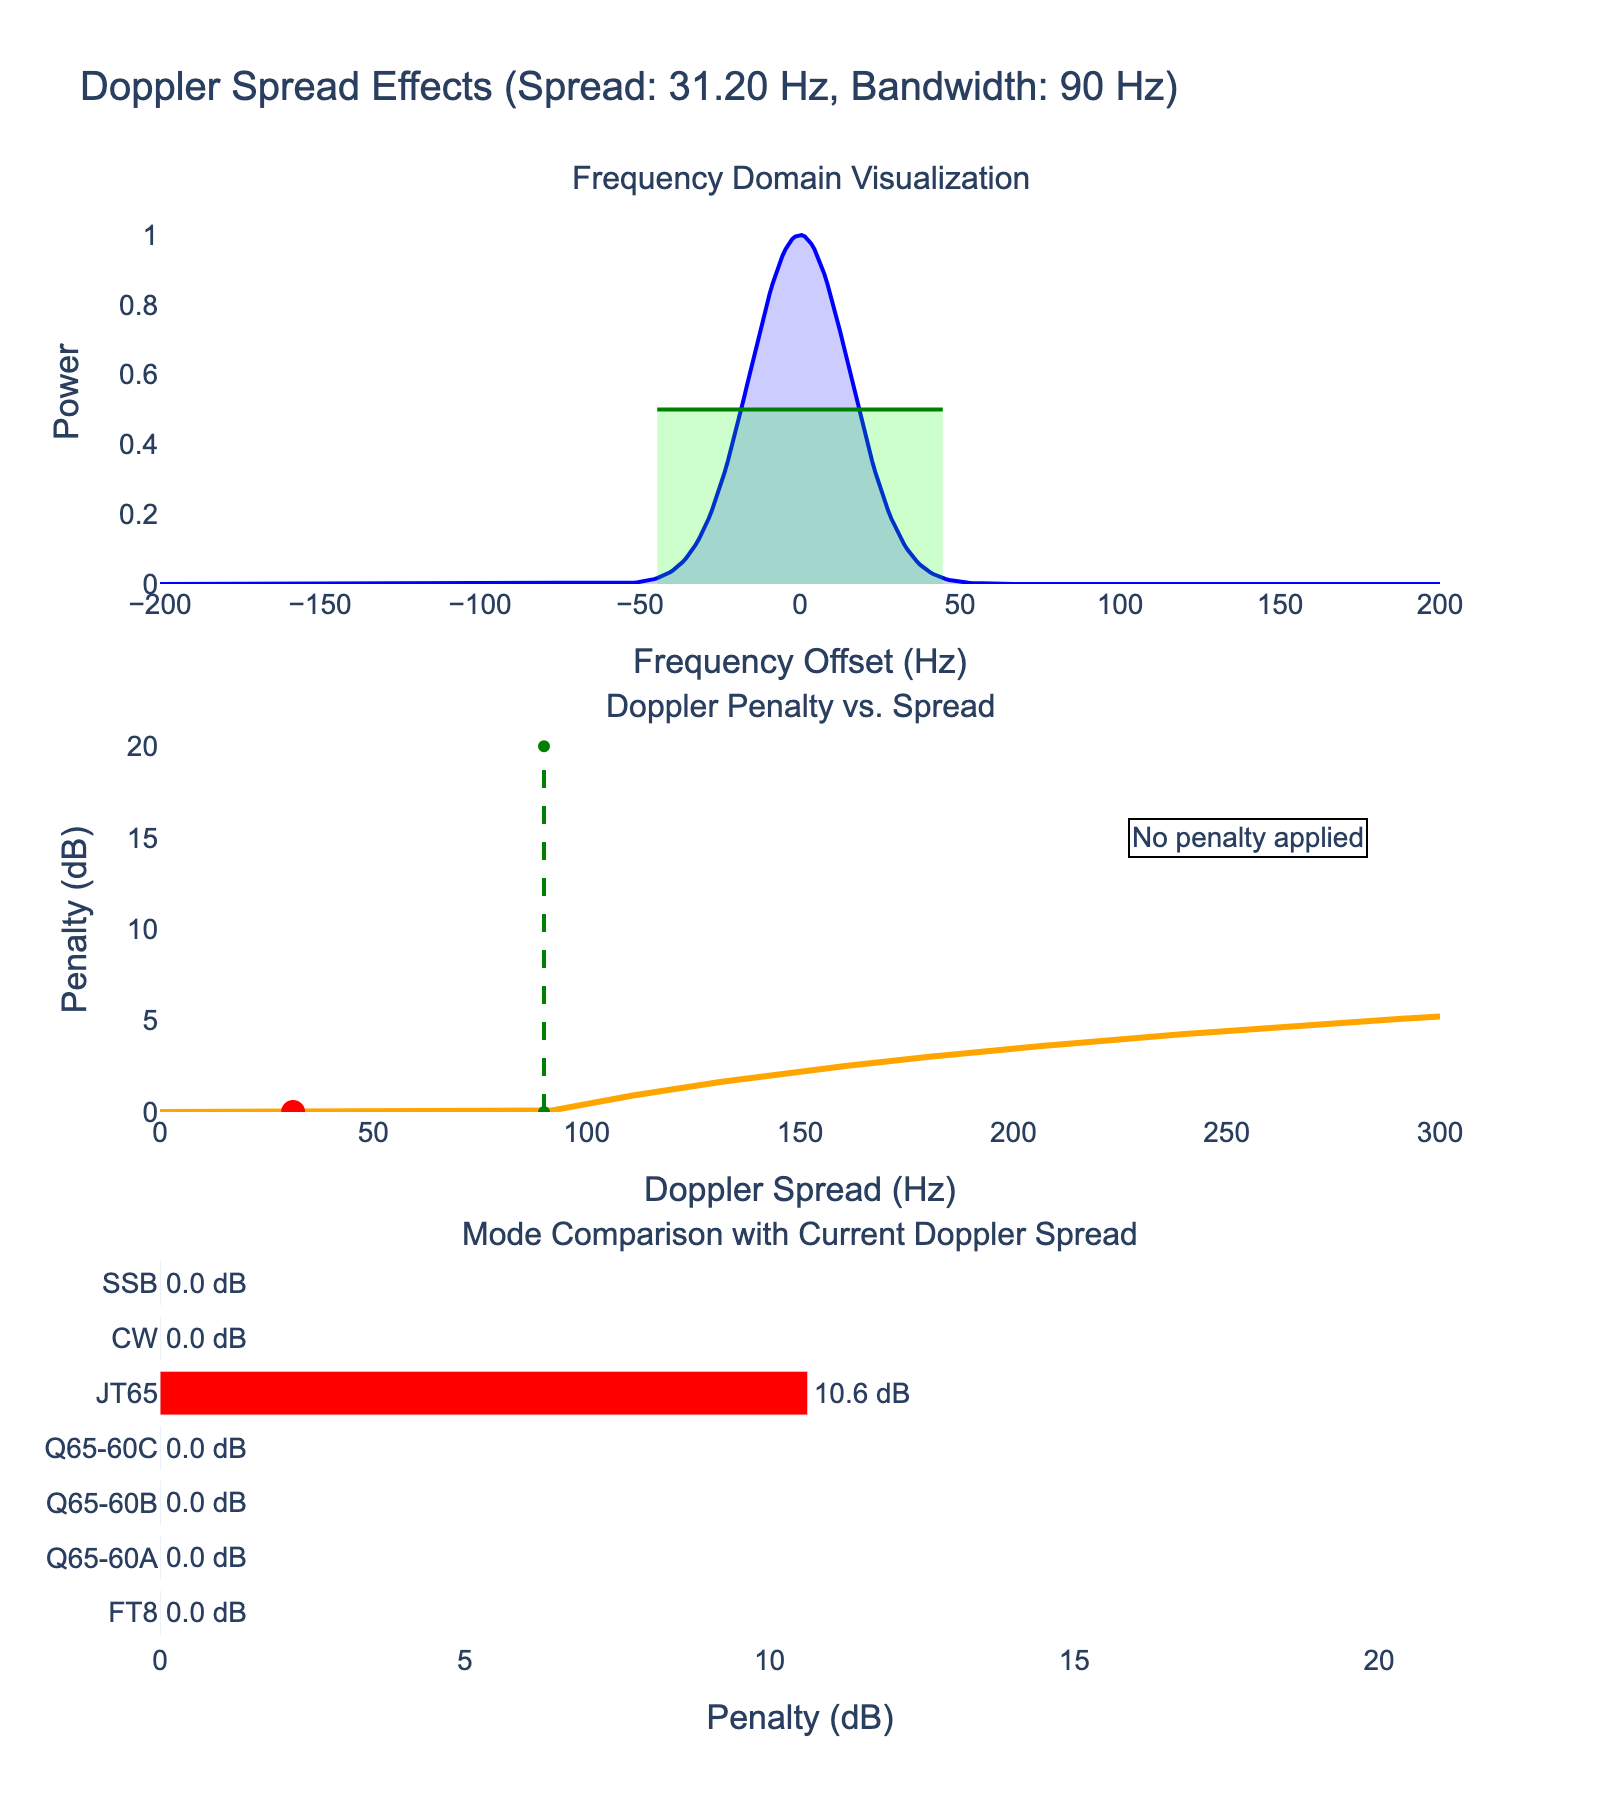

In [89]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import math

class EVEDopplerSpread: 
    def __init__(self, params):
        self.params = params

    def calculate_penalty(self, doppler_spread, mode_bandwidth):
        if doppler_spread > mode_bandwidth:
            penalty = 10 * math.log10(doppler_spread / mode_bandwidth) # our simple model of Doppler spread penalty
            return min(penalty, 20) # limit the damage to 20 dB - after that it doesn't really matter.
        return 0
        

    def venus_doppler_spread(self):
        # Convert MHz to Hz for calculations
        frequency_hz = self.params.tx_frequency_mhz * 1e6
        doppler_spread = (4 * 1.8 * frequency_hz) / self.params.c
        print(f"We calculated a Doppler spread of: {doppler_spread:.2f} Hz")
        return doppler_spread

# Create a calculator for Doppler Spread
DopplerSpreadCalculator = EVEDopplerSpread(params)

# Set parameters 
doppler_spread = DopplerSpreadCalculator.venus_doppler_spread()
mode_bandwidth = 90  # Change this value to see different scenarios (Hz)

# Calculate penalty
penalty = DopplerSpreadCalculator.calculate_penalty(doppler_spread, mode_bandwidth)
max_doppler = 300 # put a limit of the penalty 

# Create figure with subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        "Frequency Domain Visualization",
        "Doppler Penalty vs. Spread",
        "Mode Comparison with Current Doppler Spread"
    ),
    vertical_spacing=0.1,
    specs=[[{"type": "xy"}], [{"type": "xy"}], [{"type": "xy"}]]
)

# Plot 1: Frequency domain visualization
x = np.linspace(-200, 200, 400)
center_freq = 0

# Signal with Doppler spread represented as a Gaussian function
signal = np.exp(-((x - center_freq) ** 2) / (2 * (doppler_spread/2) ** 2))

# Mode bandwidth indicator
bandwidth_x = x[(np.abs(x) <= mode_bandwidth/2)]
bandwidth_y = np.ones_like(bandwidth_x) * 0.5

fig.add_trace(
    go.Scatter(
        x=x, y=signal, 
        fill='tozeroy', 
        name='Signal Power', 
        line=dict(color='blue'), 
        fillcolor='rgba(0, 0, 255, 0.2)'
    ), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=bandwidth_x, y=bandwidth_y, 
        fill='tozeroy', 
        name='Mode Bandwidth', 
        line=dict(color='green'), 
        fillcolor='rgba(0, 255, 0, 0.2)'
    ), 
    row=1, col=1
)

# Plot 2: Doppler Penalty vs. Spread calculated and shown
spreads = np.linspace(0, max_doppler, 1000)
penalties = np.array([DopplerSpreadCalculator.calculate_penalty(s, mode_bandwidth) for s in spreads])

fig.add_trace(
    go.Scatter(
        x=spreads, y=penalties,
        name='Penalty Function',
        line=dict(color='orange', width=3)
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=[mode_bandwidth, mode_bandwidth], y=[0, 20],
        name='Bandwidth Threshold',
        line=dict(color='green', width=2, dash='dash')
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=[doppler_spread], y=[penalty],
        name='Current Setting',
        mode='markers',
        marker=dict(color='red', size=12)
    ),
    row=2, col=1
)

# Add annotation for formula
if doppler_spread > mode_bandwidth:
    formula_text = f"Penalty = 10*log₁₀({doppler_spread:.2f}/{mode_bandwidth}) = {penalty:.2f} dB"
else:
    formula_text = "No penalty applied"

fig.add_annotation(
    x=max_doppler * 0.85, y=15,
    text=formula_text,
    showarrow=False,
    bgcolor="white",
    bordercolor="black",
    borderwidth=1,
    xref="x2", yref="y2"
)

# Plot 3: Mode Comparison
modes = ["FT8", "Q65-60A", "Q65-60B", "Q65-60C", "JT65", "CW", "SSB"]
bandwidths = [50, 65, 90, 180, 2.7, 250, 2500]
mode_penalties = [DopplerSpreadCalculator.calculate_penalty(doppler_spread, bw) for bw in bandwidths]

colors = ['red' if p > 10 else 'green' for p in mode_penalties]

fig.add_trace(
    go.Bar(
        y=modes, x=mode_penalties,
        orientation='h',
        marker_color=colors,
        text=[f"{p:.1f} dB" for p in mode_penalties],
        textposition='outside'
    ),
    row=3, col=1
)

# Update layout with improved settings
fig.update_layout(
    height=900,
    width=800,
    title_text=f"Doppler Spread Effects (Spread: {doppler_spread:.2f} Hz, Bandwidth: {mode_bandwidth} Hz)",
    showlegend=False,
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=14)
)

fig.update_xaxes(title_text="Frequency Offset (Hz)", range=[-200, 200], row=1, col=1)
fig.update_yaxes(title_text="Power", range=[0, 1.1], row=1, col=1)

fig.update_xaxes(title_text="Doppler Spread (Hz)", range=[0, max_doppler], row=2, col=1)
fig.update_yaxes(title_text="Penalty (dB)", range=[0, 21], row=2, col=1)

fig.update_xaxes(title_text="Penalty (dB)", range=[0, 21], row=3, col=1)

# Show figure (interactive version)
#fig.show()


# Also create a static version for better PDF export
from IPython.display import Image, display
img_bytes = pio.to_image(fig, format="png", width=800, height=900, scale=2)
display(Image(img_bytes))

## Mode Analysis

This class does an analysis of potential modes and their suitability for the the link. 

The relationship between the CNR from the link budget object (calculated at the operational receiver bandwidth) and SNR of particular signals (given at different bandwidths) may be needed. The conversion is not always straightforward. The listed SNRs for many amateur modes are given with a bandwidth, but that given SNR is not calculated at that bandwidth, but is calculated at another "normalized" bandwidth. The most common "normalized" bandwidth is 2500 Hz. When we know this is the case, we can list this number (2500 Hz) as the "real" noise bandwidth as the "noise_bandwidth_hz" value. 

The mathematics to make sure we're 

SNR = CNR × (BW_CNR / BW_SNR)

We've updated our Doppler spread model to use a Gaussian representation (as see in the Doppler Spread section above) which better reflects the physical reality of how Doppler affects signals. Instead of assuming a flat distribution of energy across frequencies (a linear model), we model the Doppler-shifted energy as following a bell curve centered at the carrier frequency.

The penalty is calculated by determining what percentage of the signal's energy falls outside the mode's bandwidth. For modes with bandwidth much wider than the Doppler spread, almost all energy is contained within the bandwidth and there's minimal penalty. As the bandwidth narrows relative to the spread, more energy falls outside the usable bandwidth, increasing the penalty. The modes most affected are the very narrow-band modes. 

This Gaussian approach is more accurate because it accounts for the concentration of energy near the carrier frequency with decreasing energy at the edges, which corresponds to the probability distribution of relative velocities in the signal path.

In [90]:
#import numpy as np
#import pandas as pd

class AmateurRadioModeEvaluator:
    """
    A class to evaluate the suitability of amateur radio modes based on link parameters. 
    """
    
    def __init__(self, params: SiteLinkParameters):
        self.params = params        
        # Define common amateur radio modes with their characteristics
        self.modes = [
            {"name": "CW", "bandwidth_hz": 250, "required_snr_db": -15, "noise_bandwidth_hz": 250},
            {"name": "FT8", "bandwidth_hz": 50, "required_snr_db": -20, "noise_bandwidth_hz": 2500},
            {"name": "JT65", "bandwidth_hz": 2.7, "required_snr_db": -25, "noise_bandwidth_hz": 2500},
            {"name": "SSB", "bandwidth_hz": 2500, "required_snr_db": 8, "noise_bandwidth_hz": 2500},
            {"name": "FM", "bandwidth_hz": 12500, "required_snr_db": 12, "noise_bandwidth_hz": 12500},
            {"name": "RTTY", "bandwidth_hz": 250, "required_snr_db": 5, "noise_bandwidth_hz": 250},
            {"name": "PSK31", "bandwidth_hz": 31, "required_snr_db": 4, "noise_bandwidth_hz": 31},
            {"name": "FT4", "bandwidth_hz": 90, "required_snr_db": -17, "noise_bandwidth_hz": 2500},
            {"name": "JS8", "bandwidth_hz": 30, "required_snr_db": -18, "noise_bandwidth_hz": 2500},

            # WSPR Modes
            {"name": "WSPR-15", "bandwidth_hz": 6, "required_snr_db": -32, "noise_bandwidth_hz": 2500},   # 15-minute
            {"name": "WSPR-2", "bandwidth_hz": 6, "required_snr_db": -28, "noise_bandwidth_hz": 2500},    # 2-minute mode (classic WSPR mode??)
            {"name": "WSPR-120", "bandwidth_hz": 6, "required_snr_db": -37, "noise_bandwidth_hz": 2500},  # 120-minute mode,
            {"name": "WSPR-LF", "bandwidth_hz": 6, "required_snr_db": -30, "noise_bandwidth_hz": 2500},   # Low frequency band modes (??)
            {"name": "WSPR-H", "bandwidth_hz": 12, "required_snr_db": -26, "noise_bandwidth_hz": 2500},   # High-speed variant with doubled bandwidth
            
            # Q65 modes (various submodes A-E with different tone spacing and durations)
            {"name": "Q65-15A", "bandwidth_hz": 65, "required_snr_db": -26, "noise_bandwidth_hz": 2500},  # 15-second mode A
            {"name": "Q65-30A", "bandwidth_hz": 65, "required_snr_db": -27, "noise_bandwidth_hz": 2500},  # 30-second mode A
            {"name": "Q65-60A", "bandwidth_hz": 65, "required_snr_db": -28, "noise_bandwidth_hz": 2500},  # 60-second mode A
            {"name": "Q65-120A", "bandwidth_hz": 65, "required_snr_db": -29, "noise_bandwidth_hz": 2500}, # 120-second mode A
            {"name": "Q65-300A", "bandwidth_hz": 65, "required_snr_db": -30, "noise_bandwidth_hz": 2500}, # 300-second mode A
            
            {"name": "Q65-15B", "bandwidth_hz": 90, "required_snr_db": -26, "noise_bandwidth_hz": 2500},  # Mode B - [ ] wider tone spacing
            {"name": "Q65-30B", "bandwidth_hz": 90, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60B", "bandwidth_hz": 90, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120B", "bandwidth_hz": 90, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300B", "bandwidth_hz": 90, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15C", "bandwidth_hz": 180, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode C - [ ] even wider spacing
            {"name": "Q65-30C", "bandwidth_hz": 180, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60C", "bandwidth_hz": 180, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120C", "bandwidth_hz": 180, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300C", "bandwidth_hz": 180, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15D", "bandwidth_hz": 360, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode D
            {"name": "Q65-30D", "bandwidth_hz": 360, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60D", "bandwidth_hz": 360, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120D", "bandwidth_hz": 360, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300D", "bandwidth_hz": 360, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
            
            {"name": "Q65-15E", "bandwidth_hz": 720, "required_snr_db": -26, "noise_bandwidth_hz": 2500}, # Mode E - [ ] widest spacing
            {"name": "Q65-30E", "bandwidth_hz": 720, "required_snr_db": -27, "noise_bandwidth_hz": 2500},
            {"name": "Q65-60E", "bandwidth_hz": 720, "required_snr_db": -28, "noise_bandwidth_hz": 2500},
            {"name": "Q65-120E", "bandwidth_hz": 720, "required_snr_db": -29, "noise_bandwidth_hz": 2500},
            {"name": "Q65-300E", "bandwidth_hz": 720, "required_snr_db": -30, "noise_bandwidth_hz": 2500},
        
            # FST4 Modes
            {"name": "FST4-15", "bandwidth_hz": 67, "required_snr_db": -21, "noise_bandwidth_hz": 2500},  # 15-second mode A
            {"name": "FST4-30", "bandwidth_hz": 29, "required_snr_db": -24, "noise_bandwidth_hz": 2500},  # 30-second mode A
            {"name": "FST4-60", "bandwidth_hz": 12, "required_snr_db": -28, "noise_bandwidth_hz": 2500},  # 60-second mode A
            {"name": "FST4-120", "bandwidth_hz": 6, "required_snr_db": -31, "noise_bandwidth_hz": 2500}, # 120-second mode A
            {"name": "FST4-300", "bandwidth_hz": 2, "required_snr_db": -35, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4-900", "bandwidth_hz": 0.7, "required_snr_db": -40, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4-1800", "bandwidth_hz": 0.4, "required_snr_db": -43, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4W-120", "bandwidth_hz": 6, "required_snr_db": -32, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4W-300", "bandwidth_hz": 2, "required_snr_db": -37, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4W-900", "bandwidth_hz": 0.7, "required_snr_db": -42, "noise_bandwidth_hz": 2500}, # 300-second mode A
            {"name": "FST4W-1800", "bandwidth_hz": 0.4, "required_snr_db": -45, "noise_bandwidth_hz": 2500} # 300-second mode A
        ]
    
    def add_mode(self, name, bandwidth_hz, required_snr_db, noise_bandwidth_hz):
        """
        Add a new mode to the evaluator.
        
        Parameters:
        name (str): Name of the mode
        bandwidth_hz (float): Bandwidth of the mode in Hz
        required_snr_db (float): Required SNR in dB for the mode to function
        noise_bandwidth_hz (float): over what bandwidth is the required_snr_db given?
        """
        new_mode = {
            "name": name,
            "bandwidth_hz": bandwidth_hz,
            "required_snr_db": required_snr_db,
            "noise_bandwidth_hz": noise_bandwidth_hz
        }
        self.modes.append(new_mode)
    
    def evaluate_modes(self, doppler_spread_hz=None):
        """
        Evaluate suitability of amateur radio modes based on link CNR
        
        Parameters:
        cnr_db (float): Carrier-to-Noise Ratio in dB already calculated at receiver_noise_bandwidth
        receiver_noise_bandwidth (float): Receiver noise bandwidth in Hz used for the CNR calculation
        doppler_spread_hz (float, optional): Doppler spread in Hz, if we have it
        
        Returns:
        DataFrame: Modes with suitability assessment
        """
        results = []
    
        # Get the CNR in 1 Hz result from link budget calculator
        print(f"from the Link Budget calculator, our min cnr_db_1hz is {min_results['cnr_db_1hz']:.2f}")
    
        for mode in self.modes:
            # Scale each mode SNR from noise bandwidth to 1Hz bandwidth
            # Some SNRs are taken really at 2500 Hz, and some are not. 
            # We made a table column to handle this.
            # noise_bandwidth_hz is the "real" number to scale by. 
            snr_db_1hz = mode["required_snr_db"] + 10 * np.log10(mode["noise_bandwidth_hz"])
            
            # Apply Doppler spread penalty if applicable using a Gaussian model or symbol time model
            # set penalty to zero just in case things get weird
            doppler_penalty_db = 0
            
            if doppler_spread_hz is not None and doppler_spread_hz > 0:
                # Determine if the mode uses coherent integration
                # Q65, JT65, FST4, WSPR, and other digital modes use coherent integration
                uses_coherent_integration = any(prefix in mode["name"] for prefix in ["Q65", "JT", "FST4", "WSPR", "FT"])
                
                if uses_coherent_integration:
                    # Extract symbol duration based on mode name (avoids extra column in table... for now)
                    # For Q65 modes, extract the time from the name (e.g., Q65-60A is 60 seconds)
                    if "Q65" in mode["name"]:
                        # Extract time value between "Q65-" and the letter at the end
                        time_str = mode["name"].split("-")[1][:-1]  # Remove the last character (A,B,C,D,E)
                        symbol_duration = float(time_str)
                    elif "FST4" in mode["name"] or "WSPR" in mode["name"]:
                        # Extract time value after the dash
                        time_str = mode["name"].split("-")[1]
                        # Handle special case for WSPR-LF and WSPR-H
                        if time_str.isdigit() or time_str.isnumeric():
                            symbol_duration = float(time_str)
                        else:
                            # Default values if we can't extract
                            symbol_duration = 120 if "WSPR" in mode["name"] else 60
                    elif "FT8" in mode["name"]:
                        symbol_duration = 15
                    elif "FT4" in mode["name"]:
                        symbol_duration = 7.5
                    elif "JT65" in mode["name"]:
                        symbol_duration = 60
                    else:
                        # Default to a reasonable value if we can't determine
                        symbol_duration = 60
                    
                    # Calculate Doppler penalty using the coherent integration formula
                    # Use the symbol_duration based approach recommended by Gary
                    '''
                    The condition if doppler_spread_hz * symbol_duration > 1: 
                    represents an important threshold in communication theory 
                    called the "coherence threshold" or "spreading factor threshold."
                    
                    When a signal experiences Doppler spread, the phase of the signal 
                    changes during reception. The product doppler_spread_hz * symbol_duration 
                    tells you how many cycles of phase change occur during one symbol period.
                    
                    If this product is less than 1, it means the phase doesn't 
                    complete a full cycle during the symbol duration. In this case, 
                    the coherent detection can still work effectively with minimal degradation. 
                    So we test for this and let it go with 0 dB penalty. 
                    
                    If this product is greater than 1, it means the phase completes one or 
                    more full cycles during a single symbol. This causes significant 
                    degradation in coherent detection because the phase changes too much to maintain coherence.
                    So we apply the Doppler spread penalty.
                    '''
                    if doppler_spread_hz * symbol_duration > 1:
                        doppler_penalty_db = 10 * math.log10(doppler_spread_hz * symbol_duration)
                        doppler_penalty_db = min(doppler_penalty_db, 200)  # Cap at 200 dB  #***************
                    else:
                        doppler_penalty_db = 0
                else:
                    # For non-coherent modes (CW, SSB, RTTY, etc.)
                    # Use the original bandwidth-based approach and Gaussian model. 
                    if doppler_spread_hz > mode["bandwidth_hz"]:
                        doppler_penalty_db = 10 * math.log10(doppler_spread_hz / mode["bandwidth_hz"])
                        doppler_penalty_db = min(doppler_penalty_db, 200)  # Cap the penalty at 200 dB  #********
                    else:
                        doppler_penalty_db = 0






                        
            
            # Calculate final effective SNR in 1Hz with Doppler penalty
            effective_snr_db_1hz = snr_db_1hz + doppler_penalty_db
            
            # Calculate margin between CNR in 1Hz and required SNR for mode in 1Hz
            margin_db = min_results['cnr_db_1hz'] - effective_snr_db_1hz
            
            # Determine reliability level
            if margin_db >= 10:
                reliability = "Excellent"
            elif margin_db >= 6:
                reliability = "Very Good"
            elif margin_db >= 3:
                reliability = "Good"
            elif margin_db >= 0:
                reliability = "Marginal"
            else:
                reliability = "Not Feasible"
            
            result = {
                "Mode": mode["name"],
                "Mode BW (Hz)": mode["bandwidth_hz"],
                "Mode SNR (dB)": mode["required_snr_db"],
                "Mode SNR 1hz (dB)": round(effective_snr_db_1hz, 1),
                "Margin (dB)": round(margin_db, 1),
                "Reliability": reliability,
                "Feasible": margin_db >= 0
            }
            
            # Add Doppler information if provided
            if doppler_spread_hz is not None:
                result["Doppler Spread (Hz)"] = doppler_spread_hz
                result["Doppler Penalty (dB)"] = round(doppler_penalty_db, 1)
            
            results.append(result)
        
        # Convert to DataFrame for easy display
        results_df = pd.DataFrame(results)
        
        # Sort by margin (highest first)
        results_df = results_df.sort_values(by="Margin (dB)", ascending=False)
        
        return results_df
    
    def filter_by_mode_type(self, results_df, mode_type):
        """
        Filter results by mode type (e.g., 'Q65', 'WSPR', etc.)
        
        Parameters:
        results_df (DataFrame): Results from evaluate_modes
        mode_type (str): Mode type to filter for
        
        Returns:
        DataFrame: Filtered results
        """
        return results_df[results_df['Mode'].str.contains(mode_type)]
    
    def get_feasible_modes(self, results_df):
        """
        Get only feasible modes from results
        
        Parameters:
        results_df (DataFrame): Results from evaluate_modes
        
        Returns:
        DataFrame: Only feasible modes
        """
        return results_df[results_df['Feasible'] == True]


        
# Example usage:
params = SiteLinkParameters()
evaluator = AmateurRadioModeEvaluator(params)
results = evaluator.evaluate_modes()

print('Results Without Considering Doppler Spread:\n')
print(results.to_string())

print(f"\n\n\n")

# # With Doppler:
print('Results Including Doppler Spread:\n')
# get extent of current Doppler Spread
doppler_spread_hz = DopplerSpreadCalculator.venus_doppler_spread()
# run evaluator with calculated Doppler Spread
results_with_doppler = evaluator.evaluate_modes(doppler_spread_hz)

print(results_with_doppler.to_string())

print(f"\n\n\n")

# # Filter for specific mode types:
print('Results Filtered for Q65 Modes:\n')
q65_modes = evaluator.filter_by_mode_type(results, 'Q65')
print(q65_modes.to_string())

print(f"\n\n\n")

# # Only feasible modes - no Doppler spread
print('Results Filtered for Feasible Modes Without Considering Doppler Spread:\n')
only_feasible_results = evaluator.get_feasible_modes(results)
print(only_feasible_results.to_string())

print(f"\n\n\n")

# # Only feasible modes - with Doppler
print('Results Filtered for Feasible Modes Including Doppler Spread:\n')
only_feasible_results = evaluator.get_feasible_modes(results_with_doppler)
print(only_feasible_results.to_string())

from the Link Budget calculator, our min cnr_db_1hz is -6.32
Results Without Considering Doppler Spread:

          Mode  Mode BW (Hz)  Mode SNR (dB)  Mode SNR 1hz (dB)  Margin (dB)   Reliability  Feasible
49  FST4W-1800           0.4            -45              -11.0          4.7          Good      True
45   FST4-1800           0.4            -43               -9.0          2.7      Marginal      True
48   FST4W-900           0.7            -42               -8.0          1.7      Marginal      True
44    FST4-900           0.7            -40               -6.0         -0.3  Not Feasible     False
47   FST4W-300           2.0            -37               -3.0         -3.3  Not Feasible     False
11    WSPR-120           6.0            -37               -3.0         -3.3  Not Feasible     False
43    FST4-300           2.0            -35               -1.0         -5.3  Not Feasible     False
9      WSPR-15           6.0            -32                2.0         -8.3  Not Feasible     

## Zadoff-Chu Transmission Proposal

1. Do coherent integration in Zadoff-Chu segments however long we can given the worst cast Doppler rate of change. We assume that we’re going to have to do batch processing with overlapping segments to ensure no signal is missed. 
2. Do a Doppler compensation between segments. 
3. Apply a sliding Doppler compensation during correlation processing
4. Combine resulting segments non-coherently until we know we can close the link.
5. Return detection result.

### Minimum Integration Time with get_integration_time()

What is the minimum integration time given our Doppler rate of change? 

We calculate the maximum doppler rate of change to find this number, and then use that as a fixed value for our Zadoff-Chu seqeunces. 

Coherent integration time is calculated by how long it takes to exceed a 45 degree phase shift. This number is equal to square root of (0.25/Doppler rate of change). This equation is from "Fundamentals of Radar Signal Processing" by Mark Andrew Richards, 2005. 

### Get Number of Chips with get_number_chips()

Number of chips in our coherent integration is (chip rate * coherent integration time). 

### Find Processing Gain with get_processing_gain()

Processing gain: is 10 * log10(number of chips in our coherent integration)

This is a large number. How can this be so high? By coherently integrating, for example, 5 MHz of bandwidth over 1.34 seconds, we're concentrating the energy of 6.7 million independent measurements into a single detection decision. 

Zadoff-Chu sequences have ideal auto-correlation properties, meaning they achieve the theoretical maximum processing gain. This is unlike other modulation schemes which suffer various losses due to inefficiencies that Zadoff-Chu sequences simply do not have. This is not without precedent or wildly made-up. NASA's deep space network uses comparable processing gain to communicate with distant spacecraft at extremely low bit rates. Radio astronomers routinely detect signals far below the noise floor using long integration times and correlation techniques like this. It’s very likely that the radio astronomy people at Dwingeloo, DSES, and other amateur sites are already familiar with this technique and  structure. This part of the link budget worksheet is an attempt to tune the technique for EVE from amateur sites with achievable configurations and parameters. 

This proposal is designed around a calculated worst case Doppler rate limitation for Venus of -0.14 Hz/second, ensuring optimal coherent processing during the worst case channel condition, which happens to occur at inferior conjunction. 

### Is Processing Gain Enough? Compare to Bandwidth Expansion with get_bandwidth_expansion()

Let’s see where we are with our CNR, assuming DSES numbers. 

For example,
CNR in 1 Hz bandwidth = -8.65 dB
CNR in 5 MHz bandwidth = -8.65 dB - 10 * log(5×10^6) = -8.65 dB - 67 dB = -75.65 dB
Processing gain for 5 MHz bandwidth = +68.26 dB
We have a shortfall of ~7.35 dB. 

We do a bandwidth expansion for our chip rate bandwidth with get_bandwidth_expansion() and compare to our previously calculated processing gain. 

Our processing gain, calculated with the limitation of the Doppler rate shift on the sequence length, doesn’t quite get us there. What can we do? There’s three things we can look at. First, we can do multiple non-coherent integrations (e.g., 10 non-coherent integrations would add ~5 dB). We can try a slightly longer coherent integration time if Doppler allows. We designed for the worst case, at inferior conjunction. This is the best place to try EVE, so we are probably stuck with this limitation. Or, we can use some error correction coding for actual data transmission. 

Using JPL's work as a model, let’s do multiple non-coherent integrations. This is under our control, doesn’t add as much complexity as adding error correction, and doesn’t run the risk of blowing past a physical Doppler limit when we have the lowest path loss. 

We use a dual-stage processing strategy. First, we perform coherent integration within the Doppler-limited window of (for example) 1.34 seconds across a 5 MHz bandwidth. Then, we combine multiple such integrations non-coherently to achieve positive SNR. This part is flexible, and can be used as Venus approaches or recedes. We just combine more sequences non-coherently. 

For example, starting with a 1 Hz CNR of -8.65 dB, the full-bandwidth 5 MHz CNR is -75.65 dB. Coherent processing provides 68.3 dB gain, yielding -7.35 dB.  

So, we need to non-coherently integrate some number of segments at inferior conjunction. Coherent processing maximizes gains within a Doppler rate of change limitation, and non-coherent integration extends processing beyond those constraints in a flexible way, depending on what our shortfall really is. Our calculations have a parameter for margin. The default is 0 dB. This parameter changes the threshold of detecion. 

#### Calculate the number of non-coherent integrations needed with get_number_noncoherent_sequences_required

At the receiver, we do a matched filtering using the known Zadoff-Chu sequence. The matched filter correlates the received signal with the expected sequence. The correlation output is examined for peaks that exceed a detection threshold. The time offset of the peak indicates the precise round-trip delay. The peak amplitude provides information about signal strength. 

Non-coherent combination works with the power (magnitude squared) of the correlation outputs rather than the complex values. For each of the non-coherently integrated sequence correlations, we calculate magnitude squared. This destroys the phase information but preserves signal energy, which is all we want at this point. Align the correlation outputs based on expected delay progression. Sum up all the magnitude squared results. This summation increases SNR by approximately 5 * log(L) where L is the number of these sequences. 

The distinction between coherent versus non-coherent combining is important when calculating processing gain from multiple observations.

Coherent combining at 10 * log10(N) is used when you can preserve both amplitude and phase information. Signals add linearly before detection. This is a "voltage addition". Power grows as N^2 where N is the number of samples, which results in 10 * log10(N) dB gain. Non-coherent combining is 5 * log10(N). This is used when only signal power or amplitude can be preserved. In other words, when phase information is lost. Signals add after detection. This is a "power addition". Power grows as N (and not N^2) where N is the number of samples. This results in 5 * log10(N) dB gain. 

Apply detection threshold to the combined result. I’m not entirely sure how to set the threshold, but correlates usually have a false-alarm detection rate and assumptions about the noise. This is the reason for having a margin parameter in the code below. The detected peaks in the non-coherent sum indicate successful reception. A detectable peak is what we are looking for. 

We can extend out the non-coherent combination until we close the link, but does this have a limit? Non-coherent is (allegedly) more resilient to phase and Doppler than coherent integration. Can we assume it's immune, or do we need a factor that scales with number of non-coherent integrations?

Each coherent segment can be processed independently, allowing for parallel implementation. This reduces the burden on the hardware compared to a huge sequence. We think that the combination of coherent processing (optimized to Doppler rate of change constraint) and non-coherent integration (for extending beyond the shortfall we still have) provides a practical approach to close the link. 

### Visualization

Below is a visualization of an example of this proposal. You can see the bandwidth expansion, followed by a processing gain for the coherent integration. This is followed by gain from non-coherent integrations of the coherent integrations. 

In [91]:
#Try to embed our SVG so we don't have to have it as a sidecar

from IPython.display import HTML
import base64

def embed_svg_content(svg_file, width=None):
    """Fully embed SVG content in the notebook (no external file needed when sharing)"""
    try:
        # Read the SVG file content
        with open(svg_file, 'r') as f:
            svg_content = f.read()
        
        # Convert to data URL for complete embedding
        svg_bytes = svg_content.encode('utf-8')
        b64 = base64.b64encode(svg_bytes).decode('utf-8')
        
        if width:
            html = f'<img src="data:image/svg+xml;base64,{b64}" width="{width}px">'
        else:
            html = f'<img src="data:image/svg+xml;base64,{b64}">'
            
        return HTML(html)
    except Exception as e:
        return HTML(f"<p>Error embedding SVG: {str(e)}</p>")
# This will fully embed the SVG - no separate file needed when sharing
embed_svg_content('eve-signal-processing-diagram.svg', width=1200)

### Doppler Spread
However, this is not the entire story. We have not yet calculated and included the Doppler Spread penalty. Doppler spread has a large effect on coherent integration, and reduces our processing gain. What is the effect of the Doppler Spread from Venus on Zadoff-Chu signals? Let's show a summary visualization and then follow with the calculations. 

In [92]:
# This will fully embed the SVG - no separate file needed when sharing
embed_svg_content('comparison-fixed.svg', width=1000)

### What about at other sites?

A different 1 Hz CNR means more or less non-coherent combinations. That’s the only change. 

### Could this be wrong?

Please let me know of any errors or oversights, and I’ll fix them. 

In [94]:
class ZadoffChuSequenceEvaluator:
    """
    A class to evaluate the suitability of Zadoff-Chu sequences based on link parameters. 
    """
    def __init__(self, params: SiteLinkParameters, chip_rate_hz: float, cnr_db_1hz: float):
        self.params = params        
        self.chip_rate_hz = chip_rate_hz
        self.cnr_db_1hz = cnr_db_1hz
        self.bandwidth_factor = 1 # in case we need to move from Time-Rate (1) to Time-Bandwidth (other than 1)

    def get_bandwidth_expansion(self) -> float:
        """        
        For our Zadoff-Chu implementation, we're assuming rectangular pulse shaping,
        so the bandwidth (W) equals the chip rate (R). Therefore, the time-bandwidth
        product (TW) equals the number of chips (TR).
        
        Processing gain = 10*log10(TW) = 10*log10(TR) = 10*log10(number of chips)
        Bandwidth expansion = 1 Hz CNR - 10*log10(R) = 1 Hz CNR - 10*log10(chip rate)

        If we want to account for pulse shaping, then the number of chips needs to
        be multiplied by a factor such as 1.2 in both get_processing_gain and 
        get_bandwidth_expansion() methods. 
        
        Change self.bandwidth_factor from 1 to the desired factor in order to
        include the TR to TW transition, due to effects from pulse shaping. 
        """
        expansion = self.cnr_db_1hz - 10 * np.log10(self.bandwidth_factor * self.chip_rate_hz)
        #print(f"Full bandwidth SNR is {expansion:.2f} dB")
        return expansion

    def get_integration_time(self) -> float:
        # first set_observer_location, in order to get accurate worst case Doppler rate of change from calculate_location_worst_case_doppler()
        DopplerCalculator.set_observer_location(params.latitude, params.longitude, params.elevation, location_name='Our Radio Site')
        my_worst_case = DopplerCalculator.calculate_location_worst_case_doppler(duration_days=584)
        #print(f"The worst case Doppler is {my_worst_case['max_rate_per_second']:.6f} Hz/second")
        Tcoh = np.sqrt((1/4)/(np.abs(my_worst_case['max_rate_per_second'])))
        #print(f"Tcoh is {Tcoh:.2f}")
        #return float(Tcoh)
        return float(1/32)

    def get_number_chips(self) -> float:
        num_chips = self.get_integration_time() * self.bandwidth_factor * self.chip_rate_hz
        #print(f"Number of chips is {num_chips:.2f}")
        return num_chips



    def calculate_doppler_spread_penalty(self) -> float:
        """
        Calculate the penalty from Doppler spread on coherent integration.
        Based on the product of Doppler spread and integration time.
        
        Returns:
        - Penalty in dB
        """
        
        # Get integration time (symbol duration for coherent integration)
        symbol_duration = self.get_integration_time()
        
        # Calculate the coherence factor
        coherence_factor = doppler_spread * symbol_duration
        # Only apply penalty if coherence factor exceeds 1
        if coherence_factor > 1:
            print(f"coherence factor of Doppler Spread * symbol duration is {coherence_factor:.2f}")
            print("Since this is larger than 1, Doppler penalty is applied.")
            penalty = 10 * np.log10(coherence_factor)
            # Cap the penalty at 200 dB #*************test
            return min(penalty, 200.0)
        else:
            return 0.0

            
 
    def get_processing_gain(self) -> float:
        """        
        For our Zadoff-Chu implementation, we're assuming rectangular pulse shaping,
        so the bandwidth (W) equals the chip rate (R). Therefore, the time-bandwidth
        product (TW) equals the number of chips (TR).
        
        Processing gain = 10*log10(TW) = 10*log10(TR) = 10*log10(number of chips)
        Bandwidth expansion = 1 Hz CNR - 10*log10(R) = 1 Hz CNR - 10*log10(chip rate)

        If we want to account for pulse shaping, then the number of chips needs to
        be multiplied by a factor such as 1.2 in both get_processing_gain and 
        get_bandwidth_expansion() methods. 
        
        Change self.bandwidth_factor from 1 to the desired factor in order to
        include the TR to TW transition, due to effects from pulse shaping. 
        """
        processing_gain = 10 * np.log10(self.get_number_chips())
        #print(f"Processing gain is {processing_gain:.2f} dB for {num_chips:.0f} chips")
        return processing_gain


    def get_processing_gain_with_doppler_spread(self) -> float:
        """
        Get the effective processing gain after accounting for Doppler spread.
        """
        # Calculate basic processing gain
        basic_gain = self.get_processing_gain()
        
        # Calculate Doppler spread penalty
        doppler_penalty = self.calculate_doppler_spread_penalty()
        
        # Apply penalty to processing gain
        effective_gain = basic_gain - doppler_penalty
        
        print(f"Basic processing gain: {basic_gain:.2f} dB")
        print(f"Doppler spread penalty: {doppler_penalty:.2f} dB")
        print(f"Basic processing gain - Doppler Penalty: {effective_gain:.2f} dB")
        
        return effective_gain


    def get_number_noncoherent_sequences_required(self) -> int:
        # Use processing gain with Doppler penalty instead of basic processing gain
        gain = self.get_processing_gain_with_doppler_spread() + self.get_bandwidth_expansion()
        print(f"The difference between Zadoff-Chu bandwidth expansion and the effective processing gain is {gain:.2f} dB")
        margin = 10.0      # in practice, a margin is usually assumed - we default to 10 dB
        print(f"We need this number to be at least {margin} dB.")
        if gain > margin: # we closed the link
            print("We closed the link with coherent integration. No further non-coherent integration needed.")
            num_noncoh_seq = 0
            return num_noncoh_seq  
        else:
            # we didn't close the link.
            # we need to non-coherently combine some number of sequences.
            # how many sequences? This loop erodes our shortfall to find out.
            count = 1
            gain = gain - margin # move our gain to where it's purely negative
            #print(f"gain is shifted by margin to be {gain}")
            gain = np.abs(gain) # turn it into a positive number to make it easier to think about
            #print(f"gain is made positive and is {gain}")
            while gain > (5 * np.log10(count)):
                #print(f"gain is {gain:.2f} dB")
                #print(f"number of non-coherent integrations so far:{count}")
                count = count + 1
            print("We didn't close the link.")
            print(f"We need to non-coherently integrate {count} sequences to produce {5 * np.log10(count):.2f} dB more gain.")
            print(f"If we do that, we should now have at least a {margin} dB margin.")
            print(f"This is {count * ZadoffChuSequenceEvaluator.get_integration_time():.1f} seconds of sequences.")
            return count


# It's 10pm, do you know where your params are?
params = SiteLinkParameters()

# Get the CNR in 1 Hz result from link budget calculator and set the chip rate
min_cnr_db_1hz = min_results['cnr_db_1hz']
print(f"from the Link Budget calculator, our min cnr_db_1hz is {min_cnr_db_1hz:.3f} dB")
chip_rate = 1e3
print(f"Our chip rate is {chip_rate} Hz")

# Create a calculator for Doppler Spread
DopplerSpreadCalculator = EVEDopplerSpread(params)
doppler_spread = DopplerSpreadCalculator.venus_doppler_spread()

# Create Zadoff-Chu Sequence Evaluator instance
ZadoffChuSequenceEvaluator = ZadoffChuSequenceEvaluator(params, chip_rate_hz = chip_rate, cnr_db_1hz = min_cnr_db_1hz)

# test get_bandwidth_expansion
expansion = ZadoffChuSequenceEvaluator.get_bandwidth_expansion()
print(f"Full bandwidth SNR for our Zadoff-Chu sequence goes from the 1 Hz bandwidth value of {min_cnr_db_1hz:.2f} dB to the chip rate bandwidth expansion of {expansion:.2f} dB")


# test get_integration_time
Tcoh = ZadoffChuSequenceEvaluator.get_integration_time()
print(f"Our maximum integration time based on the maximum Doppler rate of change is {Tcoh:.2f} seconds")


# test get_number_chips
num_chips = ZadoffChuSequenceEvaluator.get_number_chips()
print(f"The number of chips in our integration time is {num_chips:.2f}")

# test get_processing_gain
processing_gain = ZadoffChuSequenceEvaluator.get_processing_gain()
print(f"Basic processing gain for our coherent integration time is {processing_gain:.2f} dB for {num_chips:.2f} chips")

# test get_processing_gain_with_doppler_spread
processing_gain = ZadoffChuSequenceEvaluator.get_processing_gain_with_doppler_spread()
print(f"Processing gain with Doppler penalty for our coherent integration time is {processing_gain:.2f} dB for {num_chips:.2f} chips")

# test the number of non-coherent integrations needed
num_noncoh_seq = ZadoffChuSequenceEvaluator.get_number_noncoherent_sequences_required()
print(f"Recommended number of coherently integrated sequences recommended for further non-coherent integration is: {num_noncoh_seq}, for a gain of {5 * np.log10(num_noncoh_seq):.2f} dB")



from the Link Budget calculator, our min cnr_db_1hz is -6.317 dB
Our chip rate is 1000.0 Hz
We calculated a Doppler spread of: 31.20 Hz
Full bandwidth SNR for our Zadoff-Chu sequence goes from the 1 Hz bandwidth value of -6.32 dB to the chip rate bandwidth expansion of -36.32 dB
Our maximum integration time based on the maximum Doppler rate of change is 0.03 seconds
The number of chips in our integration time is 31.25
Basic processing gain for our coherent integration time is 14.95 dB for 31.25 chips
Basic processing gain: 14.95 dB
Doppler spread penalty: 0.00 dB
Basic processing gain - Doppler Penalty: 14.95 dB
Processing gain with Doppler penalty for our coherent integration time is 14.95 dB for 31.25 chips
Basic processing gain: 14.95 dB
Doppler spread penalty: 0.00 dB
Basic processing gain - Doppler Penalty: 14.95 dB
The difference between Zadoff-Chu bandwidth expansion and the effective processing gain is -21.37 dB
We need this number to be at least 10.0 dB.
We didn't close the li

## Temporal Spread Worksheet

Gary K6MG writes "One other item I didn’t see addressed is the temporal spreading of the energy. Given a 12000Km diameter for venus the returned energy gets spread over a 12e6/3e8 = 40ms window. This dual temporal/spectral spreading presents a challenge to coherently summing the returned energy to detect a weak signal. OTOH it provides astronomers the mechanism to do planetary surface mapping by pixellating the surface into delay-doppler regions.

With a chip period of 2e-7 a total of 40e-3/2e-7=2e5 PN sequences need to be summed to collect all of the returned energy."

In [95]:
print(f"diameter of Venus is: {2*calculator.venus_radius_km * 1000} m")
print(f"chip_rate_hz from Zadoff-Chu calculator is {ZadoffChuSequenceEvaluator.chip_rate_hz} Hz")
print(f"speed of light is {calculator.params.c} meters per second")
temporal_spread = (2 * calculator.venus_radius_km * 1000)/calculator.params.c
print(f"Temporal spread is {temporal_spread} seconds")
chip_period = 1/ZadoffChuSequenceEvaluator.chip_rate_hz
print(f"With a chip period of {chip_period} seconds a total of {(temporal_spread/chip_period):.2f} chips need to be summed to collect all of the returned energy.")
num_chips = ZadoffChuSequenceEvaluator.get_number_chips()
print(f"Number of chips in our Zadoff-Chu sequence is {num_chips:.2f}")


diameter of Venus is: 12103600.0 m
chip_rate_hz from Zadoff-Chu calculator is 1000.0 Hz
speed of light is 299792458 meters per second
Temporal spread is 0.04037326382640353 seconds
With a chip period of 0.001 seconds a total of 40.37 chips need to be summed to collect all of the returned energy.
Number of chips in our Zadoff-Chu sequence is 31.25


In [96]:
class PlanetaryRadarDetector:
    """
    A class to evaluate the feasibility of simple radar detection of signals
    reflected from Venus, similar to the Bochum/AMSAT-DL achievement.
    """
    def __init__(self, params: SiteLinkParameters):
        self.params = params
        
                # Venus characteristics (copied from link budget)
        self.venus_radius_km = 6051.8  # Venus radius in km
        self.venus_radar_albedo = 0.152  # see Venus radar albedo (Radio Echo Observations of Venus and Mercury at 23 cm Wavelength, 1965)
                                         # see Variations in the Radar Cross Section of Venus J. V. Evans Lincoln Laboratory,
                                         # Massachusetts Institute of Technology (Received 19 December 1967)
        
    def calculate_radar_equation_snr(self, target_distance_km=None, radar_cross_section=None):
        """
        Calculate the SNR for a radar return using the radar equation
        """
        if target_distance_km is None:
            # Use our previously established Venus distances 
            #min_distance_km = 38_000_000  # Minimum Earth-Venus distance
            #max_distance_km = 261_000_000  # Maximum Earth-Venus distance
            target_distance_km = min_distance_km  
            
        if radar_cross_section is None:
            # Use typical Venus RCS with quasi-specular reflection adjustment
            # Venus RCS is approximately π*r*r, but reduced for by radar albedo.
            # radius needs to be in meters here
            radar_cross_section = math.pi * (self.venus_radius_km * 1000)**2 * self.venus_radar_albedo  # lower still? Maybe?
            
        # Convert distance to meters
        R = target_distance_km * 1000
        
        # Calculate wavelength
        freq_hz = self.params.tx_frequency_mhz * 1e6
        wavelength = self.params.c / freq_hz
        
        # Calculate antenna gain from diameter and efficiency
        # Gain = (π*D/λ)² * efficiency
        tx_antenna_diameter = self.params.tx_antenna_diameter_m
        tx_antenna_efficiency = self.params.tx_antenna_efficiency
        tx_gain_linear = (math.pi * tx_antenna_diameter / wavelength)**2 * tx_antenna_efficiency
        
        # Calculate antenna gain in dBi for reporting
        tx_gain_dbi = 10 * math.log10(tx_gain_linear)
        print(f"Calculated antenna gain: {tx_gain_dbi:.2f} dBi")
        
        # System temperature in K
        # Calculate from System Noise Temperature calculator
        # set up calculator
        noise_calculator = SystemNoiseTemperature(params)
        # Get full noise temperature analysis with default parameters
        results = noise_calculator.get_noise_temperature_summary(
        )
        system_temp = results['noise_temperatures']['T_sys']

        
        # Use a narrower bandwidth for detection
        detection_bandwidth_hz = 3.0  # Very narrow for detection
        
        # Calculate SNR using radar equation
        snr = (self.params.tx_power_w * tx_gain_linear**2 * wavelength**2 * radar_cross_section) / \
              ((4 * math.pi)**3 * R**4 * self.params.k * system_temp * detection_bandwidth_hz)
        
        # Convert to dB
        snr_db = 10 * math.log10(snr)
        
        return snr_db
    
    def calculate_long_integration_gain(self, integration_time_seconds):
        """
        Calculate the processing gain from non-coherent long-term integration
        
        For non-coherent integration, gain increases with sqrt(N) where N is the
        number of integrated samples
        """
        # Assume 1 sample per second for simplicity
        num_samples = integration_time_seconds
        
        # Non-coherent integration gain is proportional to sqrt(N)
        gain_db = 5 * math.log10(num_samples)  # 5*log10(N) instead of 10*log10(N)
        
        return gain_db
    
    def analyze_detection_feasibility(self, integration_times=[60, 300, 900, 3600]):
        """
        Analyze the feasibility of signal detection with various integration times
        """
        results = []
        
        base_snr = self.calculate_radar_equation_snr()
        
        for time in integration_times:
            integration_gain = self.calculate_long_integration_gain(time)
            total_snr = base_snr + integration_gain
            
            # Detection margin typically requires SNR > 3dB
            # For our communications margin we used SNR >10 dB
            is_detectable = total_snr > 3
            
            result = {
                "Integration Time (s)": time,
                "Base SNR (dB)": round(base_snr, 2),
                "Integration Gain (dB)": round(integration_gain, 2),
                "Total SNR (dB)": round(total_snr, 2),
                "Detectable": is_detectable
            }
            
            results.append(result)
        
        return pd.DataFrame(results)
    
    def recommend_detection_setup(self):
        """
        Recommend parameters for successful signal detection
        """
        # Start with current parameters
        df = self.analyze_detection_feasibility()
        
        if df["Detectable"].any():
            # Find minimum integration time needed
            min_time = df[df["Detectable"]]["Integration Time (s)"].min()
            print(f"Detection possible with {min_time} seconds integration time.")
        else:
            # Recommend parameter improvements
            print("Detection not possible with current parameters.")
            print("Recommended improvements:")
            
            # Try increasing power
            power_factor = 10
            original_power = self.params.tx_power_w
            self.params.tx_power_w *= power_factor
            df_power = self.analyze_detection_feasibility()
            self.params.tx_power_w = original_power
            
            if df_power["Detectable"].any():
                print(f"- Increase transmit power by {power_factor}x to {original_power * power_factor} watts")
            
            # Try larger dish
            dish_factor = 1.5
            original_diameter = self.params.tx_antenna_diameter_m
            self.params.tx_antenna_diameter_m *= dish_factor
            df_dish = self.analyze_detection_feasibility()
            self.params.tx_antenna_diameter_m = original_diameter
            
            if df_dish["Detectable"].any():
                print(f"- Increase dish diameter by {dish_factor}x to {original_diameter * dish_factor} meters")
        
        return df

In [97]:
# Create detector instance with your parameters
params = SiteLinkParameters()
detector = PlanetaryRadarDetector(params)

# Basic analysis with different integration times
results = detector.analyze_detection_feasibility([60, 300, 900, 3600, 14400, 43200])  # Up to 12 hours
print(results)

# Get recommendations for successful detection
detector.recommend_detection_setup()

Calculated antenna gain: 49.03 dBi
   Integration Time (s)  Base SNR (dB)  Integration Gain (dB)  Total SNR (dB)  \
0                    60          -2.73                   8.89            6.16   
1                   300          -2.73                  12.39            9.66   
2                   900          -2.73                  14.77           12.04   
3                  3600          -2.73                  17.78           15.05   
4                 14400          -2.73                  20.79           18.07   
5                 43200          -2.73                  23.18           20.45   

   Detectable  
0        True  
1        True  
2        True  
3        True  
4        True  
5        True  
Calculated antenna gain: 49.03 dBi
Detection possible with 60 seconds integration time.


,Integration Time (s),Base SNR (dB),Integration Gain (dB),Total SNR (dB),Detectable
0,60,-2.73,8.89,6.16,True
1,300,-2.73,12.39,9.66,True
2,900,-2.73,14.77,12.04,True
3,3600,-2.73,17.78,15.05,True


# ORI Earth-Venus-Earth Communications Development Roadmap
Note: the checkboxes for each task listed below _may not_ automatically render if you are viewing this document on GitHub. If you want to see completed vs. uncompleted tasks, then you will need to see the PDF rendering of this document, or render it to a viewer yourself. 

### to do from 4 March 2025 meetup:

- [x] Michelle to update the link budget with 5 log10 for non-coherent averaging instead of 10 log10.
- [x] Michelle to document the change to 5 log10 for non-coherent averaging in the link budget, explaining the practical reasons for this derating.
- [x] Michelle to reach out to retired scientists with EME stations to help validate the link budget model using moon bounce data.
- [ ] Thomas to analyze the 30-second Zadoff-Chu transmission data to evaluate incoherent averaging performance in practice.
- [ ] Team to work on validating link budget assumptions by comparing model predictions for moon bounces against real EME data.
- [x] Team to review and refine the Doppler spread model in the link budget.
- [x] Team to consider lowering the target SNR requirement (Zadoff-Chu paper) to reduce required transmission duration.
- [x] Team to continue refining and improving the EVE link budget and transmission proposal.

### to do from 11 March 2025 meetup:

- [x] Michelle to consolidate imports
- [x] Michelle to move Tsys up and include calculation instead of hand edit in link budget
- [x] Michelle to do a worksheet for Temporal Spread
- [x] Michelle to consolidate pointing and tracking error worksheet
- [x] Michelle to add Dwingeloo and other potential sites to the dataclass set in the link budget.
- [x] Michelle to eliminate need for sidecar documents.
- [x] Michelle to update Doppler Spread from occupied bandwidth to symbol duration for coherent modes.

## Phase 1: Foundation and Research (3-4 months)
### Documentation and Requirements
- [x] Document full link budget analysis (this notebook)
- [x] Compile SDR Capabilities (zc706/adrv9009 or any partner SDR system)
- [x] Create detailed Doppler analysis (in this notebook)
- [x] Define custom mode specifications (CNR in 1Hz now known)
- [ ] Write FPGA requirements document

#### zc706/adrv9009 FPGA Development Board Capabilities
ADRV9009 capabilities:

-Frequency range: 75 MHz to 6 GHz (covers our 1296 MHz)
-Observation bandwidth: up to 200 MHz (plenty for our ~600 kHz Doppler range)
-12-bit ADC
-Low noise performance
-Direct sampling capability

The Zynq 7 FPGA on the zc706 provides:

-DSP slices: 900
-Block RAM: 555 × 36 Kb
-LUTs: 218,600
-Flip-flops: 437,200

#### zcu102/adrv9009 FPGA Development Board Capabilities
ADRV9009 capabilities:

-Frequency range: 75 MHz to 6 GHz (covers our 1296 MHz)
-Observation bandwidth: up to 200 MHz (plenty for our ~600 kHz Doppler range)
-12-bit ADC
-Low noise performance
-Direct sampling capability

UltraScale+ XCZU9EG on the zcu102 provides:

DSP Slices: 2,520 (vs 900 on zc706)
Block RAM: 1,824 × 36Kb (vs 555 on zc706)
UltraRAM: 960 Kb
LUTs: 548,160 (vs 218,600 on zc706)
Flip-flops: 1,096,320 (vs 437,200 on zc706)

-More parallel processing channels possible
-Better timing closure likely with UltraScale+ architecture
-UltraRAM provides additional buffer space for sample processing
-Higher achievable clock rates
-More room for future expansion/features
-Could implement more parallel demodulators for Doppler tracking

#### USRP X310 (Dwingeloo has same SDR)


#### Custom Mode Definition
In the case that no existing communications mode closes the link (see Evaluation of Modes cell below) we could design a custom "EVE-Mode" with:

- Zadoff-Chu sequences
- QPSK modulation as a baseline (good balance of spectral efficiency and robustness)
- ~5 kHz bandwidth (more than wide enough for short-term Doppler)
- Strong FEC (LDPC, Polar)
- Synchronization sequence designed for high Doppler rates
- Multiple parallel decoding paths

#### Custom Mode SDR Requirements
- Need high sample rate (>1.2 MSPS)
- Need Excellent phase noise performance
- 16-bit ADC minimum
- Very stable frequency reference

#### Custom Mode FPGA Specficiation



### Initial GNU Radio Development
- [ ] Basic flow graph implementation
- [ ] Simple Doppler tracking prototype
- [ ] Test with recorded or simulated signals/simulations
- [ ] Document processing chain

### Community Engagement
- [x] Present project on ORI channels
- [x] Recruit additional developers (mailing list, Slack)
- [x] Set up project definition and documentation (this document)

## Phase 2: Core Development (6-8 months)
### GNU Radio Implementation
- [ ] Complete mode implementation
- [ ] Doppler tracking refinement
- [ ] orbital prediction integration
- [ ] Performance monitoring tools
- [ ] User interface development

### FPGA Development
- [ ] DDC implementation?
- [ ] Initial Doppler tracking
- [ ] Memory interface design
- [ ] Basic demodulator implementation
- [ ] Testing framework development
- [ ] Does our AI/ML team have a role?

### Integration Planning
- [ ] SDR selection and acquisition: zc706/adrv9009, zcu102/adrv9009 or 9002, new hardware
- [ ] Interface definition for hardware
- [x] Test equipment requirements (Remote Labs confirmed)
- [ ] Performance measurement plans

## Phase 3: Integration and Testing (4-6 months)
### Hardware Integration
- [ ] SDR integration (do the work)
- [ ] FPGA bitstream testing (do the work)
- [ ] Timing verification (do the work)
- [ ] Performance measurements (yes, do the work)

### Software Integration
- [ ] GNU Radio to FPGA interface? 
- [ ] Control software development
- [ ] Monitoring tools - [ ] probably not required due to brevity of opportunities
- [ ] User interface refinement (standing orders)

### Testing Framework
- [ ] Automated test development (probably not needed but need to talk about)
- [ ] Performance verification (did it work or not)
- [ ] Doppler simulation testing (did our model turn out to be accurate)
- [ ] Link budget verification (did we close the link with expected margins)

## Phase 4: Optimization and Documentation (3-4 months)
### Performance Optimization (Vivado)
- [ ] FPGA resource optimization and utilization reports
- [ ] Processing chain refinement
- [ ] Doppler tracking improvements?
- [ ] Memory usage optimization

### Documentation
- [ ] User manual creation (HTML5 interface?)
- [ ] Installation guides
- [ ] Development documentation, articles, reports
- [ ] Performance reports, papers

### Community Resources
- [ ] Example configurations
- [ ] Tutorial development
- [ ] Test data publication
- [ ] Contribution guidelines

## Phase 5: Deployment and Validation (3-4 months)
### Field Testing
- [ ] Initial station setup (may be very narrow cases if remote access not available)
- [ ] Performance validation
- [ ] Doppler tracking testing
- [ ] System stability testing

### Final Documentation
- [ ] Test results publication
- [ ] Configuration guides
- [ ] Troubleshooting guides
- [ ] Performance reports

### Community Support
- [ ] Training materials
- [ ] Support documentation
- [x] Schedule of next opportunity for communications attempts October 2026
- [x] Future development plans

## Ongoing Activities
### Community Engagement
- [x] Regular progress updates (Inner Circle, email, published video recordings)
- [x] Technical presentations (IEEE vTools events)
- [ ] Conference participation
- [x] Developer meetings

### Development Support
- [x] Code review process (weekly meetups)
- [x] Bug tracking (Github Issues Tracker)
- [x] Feature requests (Slack, email, meetups)
- [ ] Performance monitoring

### Documentation Maintenance
- [x] Regular documentation updates
- [ ] Performance reports
- [x] Configuration Artifacts Recorded
- [ ] Best practices documentation

## Key Milestones
0. Jupyter Lab Notebook passes review
1. Initial GNU Radio prototype functional
2. First FPGA implementation complete
3. Basic Doppler tracking working
4. Full system integration achieved
5. First successful field tests
6. Release candidate testing complete
7. Production release with documentation

## Success Criteria
- [ ] Successful Doppler tracking at specified rates
- [ ] Reliable demodulation under varying conditions
- [ ] Meeting specified link budget parameters
- [ ] Complete, maintainable documentation
- [ ] Active community engagement
- [ ] Reproducible build process
- [ ] Comprehensive test coverage

## Risk Management
### Technical Risks
- [ ] SDR performance limitations
- [ ] FPGA resource constraints
- [ ] Doppler tracking challenges
- [ ] Integration complexities

### Mitigation Strategies
- [ ] Early prototyping
- [ ] Regular testing
- [ ] Performance monitoring
- [ ] Community feedback
- [x] Incremental development
- [x] Regular reviews

## Resource Requirements
### Hardware
- [x] Development SDRs
- [x] FPGA development boards
- [x] Test equipment
- [x] Antenna systems

### Software
- [x] FPGA development tools
- [x] GNU Radio environment
- [x] Testing frameworks
- [x] Documentation tools

### Personnel
- [x] FPGA developers
- [ ] GNU Radio developers
- [x] Documentation writers
- [x] Test engineers
- [x] Project coordinators

## Review Points
- [x] Weekly progress reviews
- [x] Monthly milestone assessments (Inner Circle Newsletter)
- [x] Community feedback sessions (vTools crosslisting, email list)
- [ ] Performance validation checks (future)
- [ ] Documentation reviews (ongoing)